Ссылка на датасет - https://www.kaggle.com/datasets/parisrohan/credit-score-classification

### Постановка задачи:
За годы работы международная финансовая компания собрала основные банковские данные и большой объем информации, связанный с кредитной историей. Руководство хочет создать интеллектуальную систему для разделения сотдруников по кредитным группам, чтобы сократить ручной труд.

### Задача:
На основе кредтиной истории человека построить модель машинного обучения, которая сможет классифицировать кредитный рейтинг человека

In [2]:
!pip install kagglehub
!pip install catboost
!pip install imbalanced-learn

In [154]:
import kagglehub
import pandas
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  
import sklearn

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

from catboost import CatBoostClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

In [4]:
def convert_income_values(value):
    value_str = str(value).strip()

    try:
        return float(value_str)
    except ValueError:
        try:
            cleaned = value_str.replace('_', '').replace(' ', '')
            return float(cleaned)
        except:
            return np.nan

In [5]:
def describe_column(column):
    print(f"Column: {column.name}")
    print(f"Data Type: {column.dtype}")
    print(f"Missing Values: {column.isnull().sum()}")
    print(f"Unique Values: {column.nunique()}")
    print("Statistical Summary:")
    print(column.describe())
    print("\n")
    print(column.value_counts())

In [6]:
def show_corr_matrix(input_df):
    corr_mat = input_df.corr()
    corr_mat
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr_mat, square=True, cmap='coolwarm', linewidths=0.5)

In [7]:
def show_confusion_matrix(y_test, y_test_predicted):
    cm = confusion_matrix(y_test, y_test_predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [8]:
# https://habr.com/ru/articles/879840/ про BoxPlot + там есть картинки с обозначениями
# круги - выбросы (аномальные значения, также они присутсвуют и для больше 200, но я их не стал визуализировать)
# все что между усов, данные, которые я буду считать корректными

def show_box_plot(data_frame, column_names):
    for column_name in column_names:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=data_frame[column_name])
        plt.title(f'Box Plot of {column_name}')
        plt.xlabel(column_name)
        plt.show()

In [9]:
path = kagglehub.dataset_download("parisrohan/credit-score-classification")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\MypkaXD\.cache\kagglehub\datasets\parisrohan\credit-score-classification\versions\1


In [10]:
df = pandas.read_csv(f'{path}\\train.csv')

C:\Users\MypkaXD\AppData\Local\Temp\ipykernel_956\432244588.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pandas.read_csv(f'{path}\\train.csv')


In [11]:
df

ID Customer_ID     Month           Name   Age          SSN  \
0       0x1602   CUS_0xd40   January  Aaron Maashoh    23  821-00-0265   
1       0x1603   CUS_0xd40  February  Aaron Maashoh    23  821-00-0265   
2       0x1604   CUS_0xd40     March  Aaron Maashoh  -500  821-00-0265   
3       0x1605   CUS_0xd40     April  Aaron Maashoh    23  821-00-0265   
4       0x1606   CUS_0xd40       May  Aaron Maashoh    23  821-00-0265   
...        ...         ...       ...            ...   ...          ...   
99995  0x25fe9  CUS_0x942c     April          Nicks    25  078-73-5990   
99996  0x25fea  CUS_0x942c       May          Nicks    25  078-73-5990   
99997  0x25feb  CUS_0x942c      June          Nicks    25  078-73-5990   
99998  0x25fec  CUS_0x942c      July          Nicks    25  078-73-5990   
99999  0x25fed  CUS_0x942c    August          Nicks    25  078-73-5990   

      Occupation Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  ...  \
0      Scientist      19114.12            1824.843333                  3  ...   
1      Scientist      19114.12                    NaN                  3  ...   
2      Scientist      19114.12                    NaN                  3  ...   
3      Scientist      19114.12                    NaN                  3  ...   
4      Scientist      19114.12            1824.843333                  3  ...   
...          ...           ...                    ...                ...  ...   
99995   Mechanic      39628.99            3359.415833                  4  ...   
99996   Mechanic      39628.99            3359.415833                  4  ...   
99997   Mechanic      39628.99            3359.415833                  4  ...   
99998   Mechanic      39628.99            3359.415833                  4  ...   
99999   Mechanic     39628.99_            3359.415833                  4  ...   

       Credit_Mix  Outstanding_Debt Credit_Utilization_Ratio  \
0               _            809.98                26.822620   
1            Good            809.98                31.944960   
2            Good            809.98                28.609352   
3            Good            809.98                31.377862   
4            Good            809.98                24.797347   
...           ...               ...                      ...   
99995           _            502.38                34.663572   
99996           _            502.38                40.565631   
99997        Good            502.38                41.255522   
99998        Good            502.38                33.638208   
99999        Good            502.38                34.192463   

           Credit_History_Age  Payment_of_Min_Amount Total_EMI_per_month  \
0       22 Years and 1 Months                     No           49.574949   
1                         NaN                     No           49.574949   
2       22 Years and 3 Months                     No           49.574949   
3       22 Years and 4 Months                     No           49.574949   
4       22 Years and 5 Months                     No           49.574949   
...                       ...                    ...                 ...   
99995   31 Years and 6 Months                     No           35.104023   
99996   31 Years and 7 Months                     No           35.104023   
99997   31 Years and 8 Months                     No           35.104023   
99998   31 Years and 9 Months                     No           35.104023   
99999  31 Years and 10 Months                     No           35.104023   

      Amount_invested_monthly                 Payment_Behaviour  \
0           80.41529543900253   High_spent_Small_value_payments   
1          118.28022162236736    Low_spent_Large_value_payments   
2             81.699521264648   Low_spent_Medium_value_payments   
3           199.4580743910713    Low_spent_Small_value_payments   
4          41.420153086217326  High_spent_Medium_value_payments   
...                       ...                               ...   

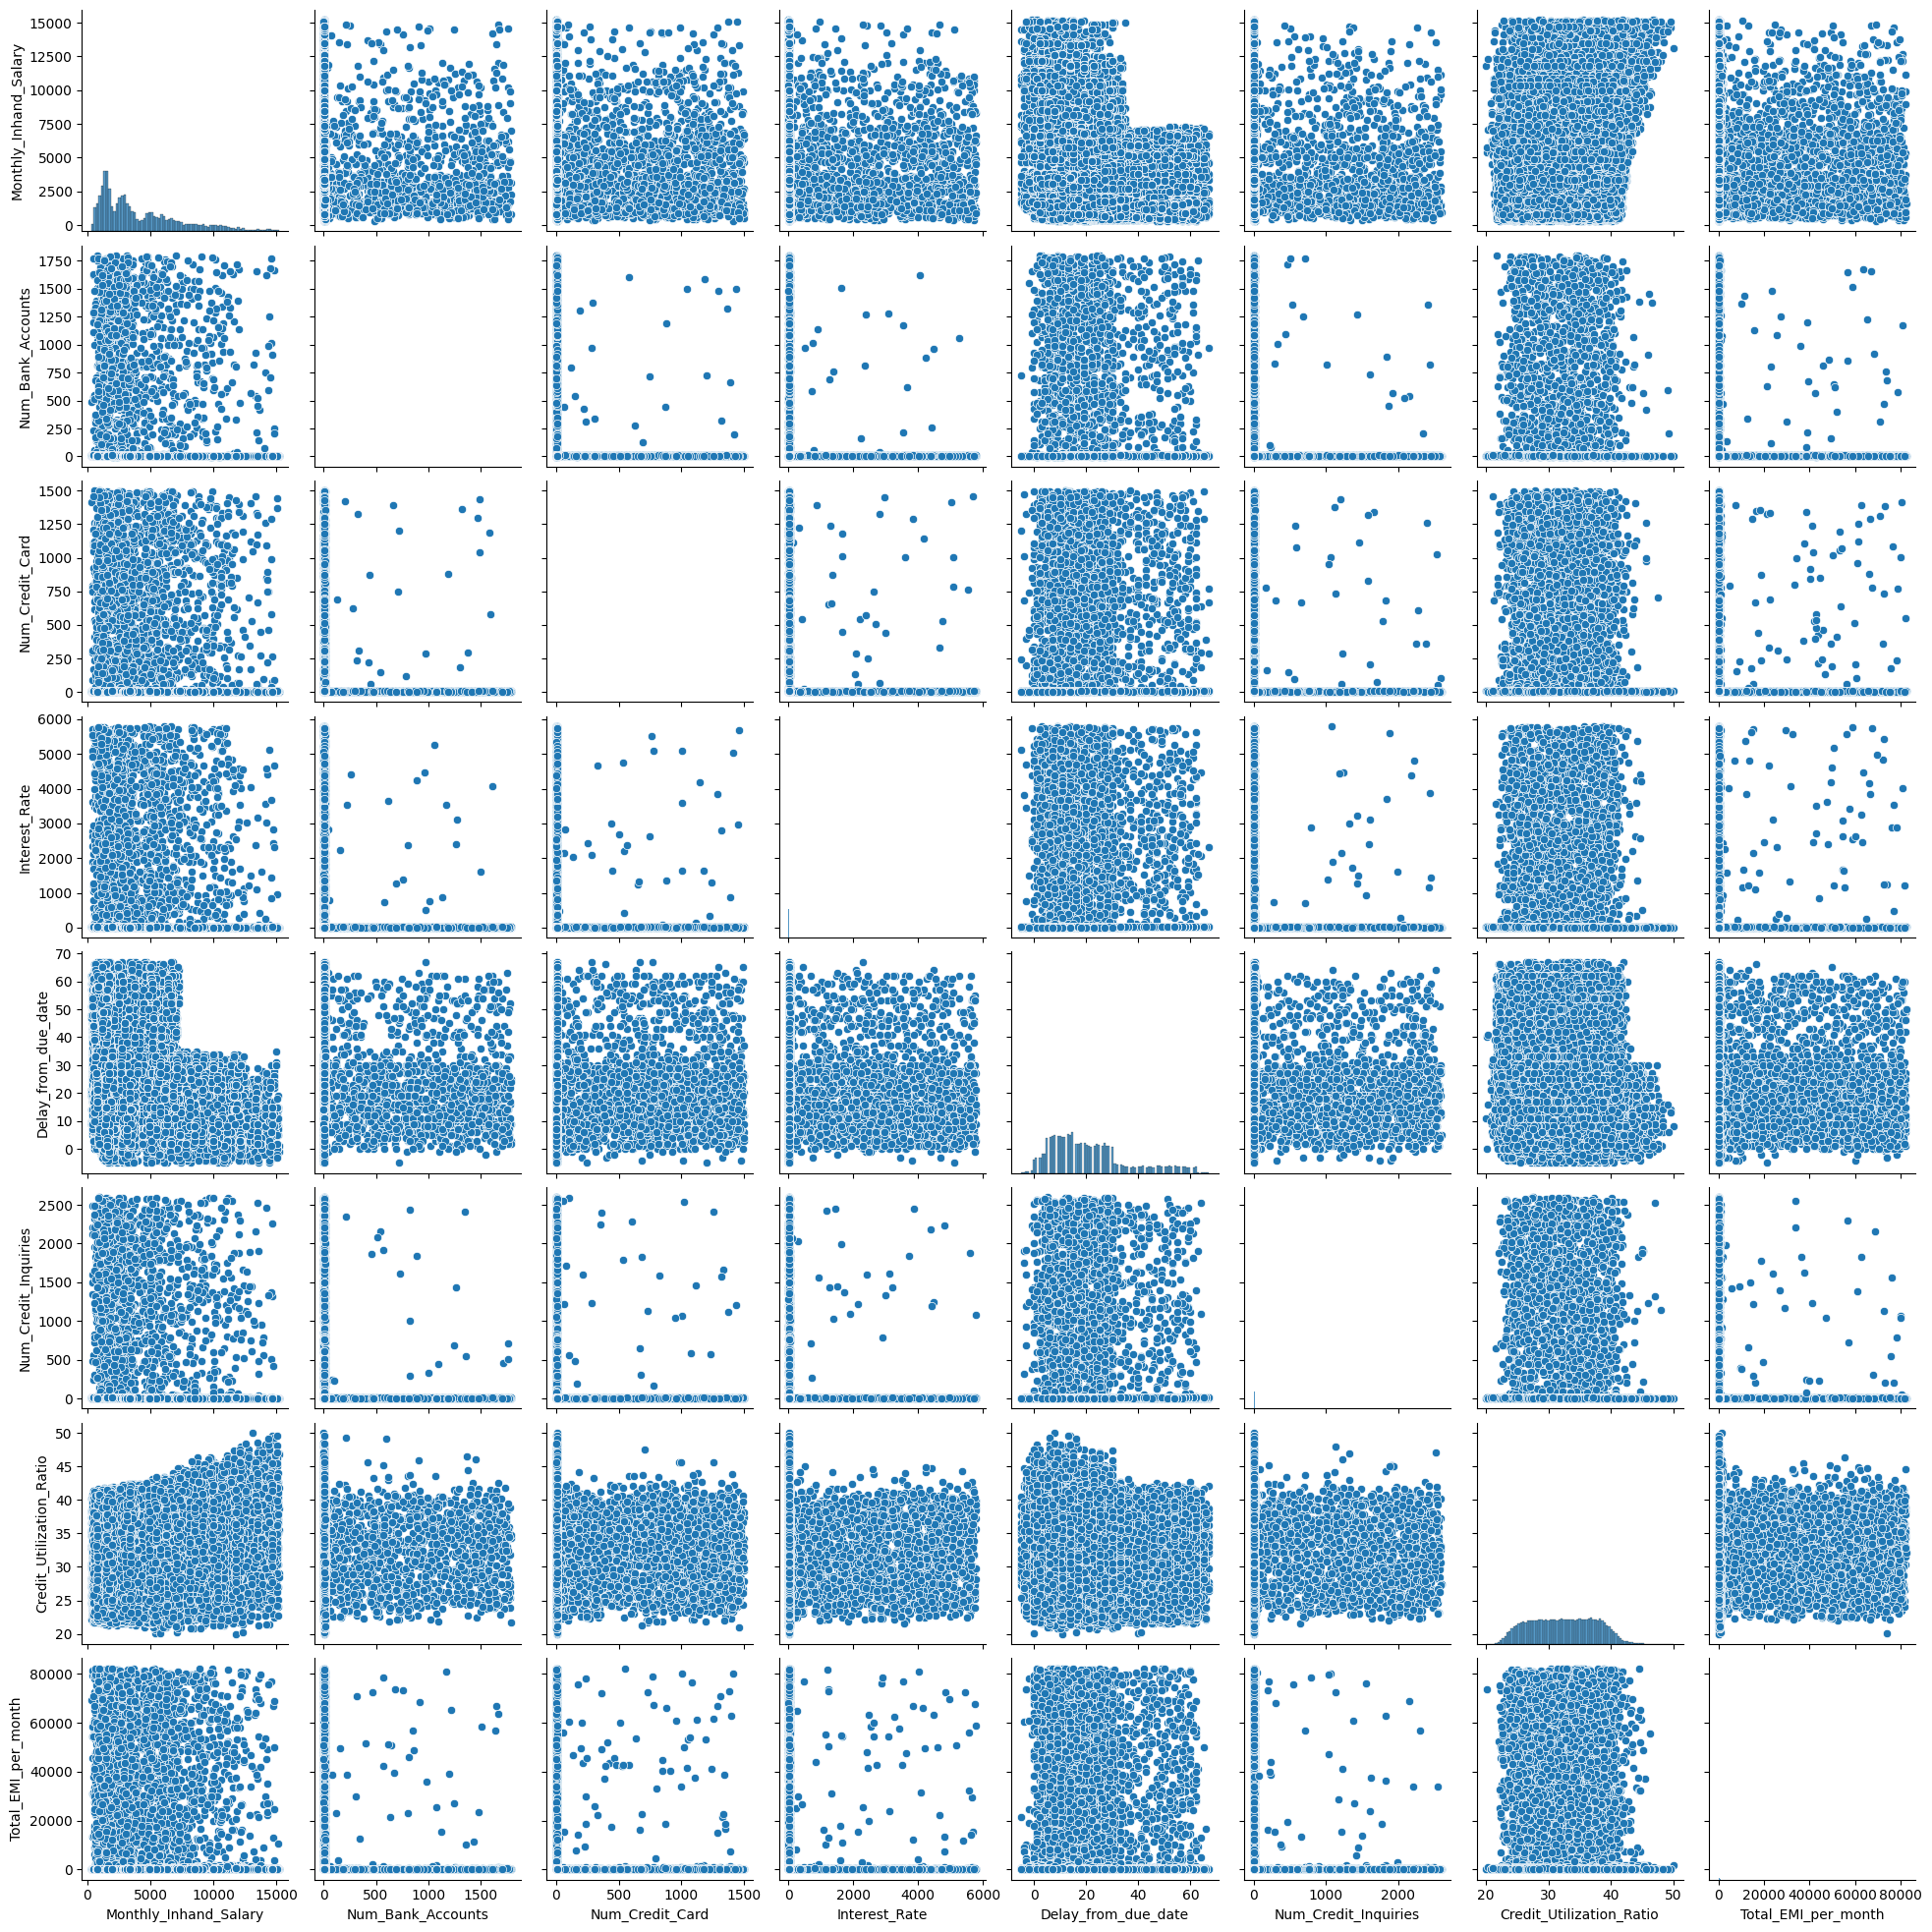

In [12]:
sns.pairplot(df)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [14]:
df.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

In [15]:
display(df.describe())

Monthly_Inhand_Salary  Num_Bank_Accounts  Num_Credit_Card  \
count           84998.000000      100000.000000     100000.00000   
mean             4194.170850          17.091280         22.47443   
std              3183.686167         117.404834        129.05741   
min               303.645417          -1.000000          0.00000   
25%              1625.568229           3.000000          4.00000   
50%              3093.745000           6.000000          5.00000   
75%              5957.448333           7.000000          7.00000   
max             15204.633333        1798.000000       1499.00000   

       Interest_Rate  Delay_from_due_date  Num_Credit_Inquiries  \
count  100000.000000        100000.000000          98035.000000   
mean       72.466040            21.068780             27.754251   
std       466.422621            14.860104            193.177339   
min         1.000000            -5.000000              0.000000   
25%         8.000000            10.000000              3.000000   
50%        13.000000            18.000000              6.000000   
75%        20.000000            28.000000              9.000000   
max      5797.000000            67.000000           2597.000000   

       Credit_Utilization_Ratio  Total_EMI_per_month  
count             100000.000000        100000.000000  
mean                  32.285173          1403.118217  
std                    5.116875          8306.041270  
min                   20.000000             0.000000  
25%                   28.052567            30.306660  
50%                   32.305784            69.249473  
75%                   36.496663           161.224249  
max                   50.000000         82331.000000

In [16]:
print(df.shape)

(100000, 28)


In [17]:
for i in range(0, len(df.columns)):
    print(f'count of NaN in {df.columns[i]} = {df[df.columns[i]].isna().sum()}')

count of NaN in ID = 0
count of NaN in Customer_ID = 0
count of NaN in Month = 0
count of NaN in Name = 9985
count of NaN in Age = 0
count of NaN in SSN = 0
count of NaN in Occupation = 0
count of NaN in Annual_Income = 0
count of NaN in Monthly_Inhand_Salary = 15002
count of NaN in Num_Bank_Accounts = 0
count of NaN in Num_Credit_Card = 0
count of NaN in Interest_Rate = 0
count of NaN in Num_of_Loan = 0
count of NaN in Type_of_Loan = 11408
count of NaN in Delay_from_due_date = 0
count of NaN in Num_of_Delayed_Payment = 7002
count of NaN in Changed_Credit_Limit = 0
count of NaN in Num_Credit_Inquiries = 1965
count of NaN in Credit_Mix = 0
count of NaN in Outstanding_Debt = 0
count of NaN in Credit_Utilization_Ratio = 0
count of NaN in Credit_History_Age = 9030
count of NaN in Payment_of_Min_Amount = 0
count of NaN in Total_EMI_per_month = 0
count of NaN in Amount_invested_monthly = 4479
count of NaN in Payment_Behaviour = 0
count of NaN in Monthly_Balance = 1200
count of NaN in Credit_

In [18]:
print(df.head(10))

       ID Customer_ID     Month             Name   Age          SSN  \
0  0x1602   CUS_0xd40   January    Aaron Maashoh    23  821-00-0265   
1  0x1603   CUS_0xd40  February    Aaron Maashoh    23  821-00-0265   
2  0x1604   CUS_0xd40     March    Aaron Maashoh  -500  821-00-0265   
3  0x1605   CUS_0xd40     April    Aaron Maashoh    23  821-00-0265   
4  0x1606   CUS_0xd40       May    Aaron Maashoh    23  821-00-0265   
5  0x1607   CUS_0xd40      June    Aaron Maashoh    23  821-00-0265   
6  0x1608   CUS_0xd40      July    Aaron Maashoh    23  821-00-0265   
7  0x1609   CUS_0xd40    August              NaN    23    #F%$D@*&8   
8  0x160e  CUS_0x21b1   January  Rick Rothackerj   28_  004-07-5839   
9  0x160f  CUS_0x21b1  February  Rick Rothackerj    28  004-07-5839   

  Occupation Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  ...  \
0  Scientist      19114.12            1824.843333                  3  ...   
1  Scientist      19114.12                    NaN               

ID - уникальный идентификатор записи (можно выкинуть)

Customer_ID - уникальная идентификация человека (можно выкинуть)

Month - месяц года (строка -> конвертируем в число от 1 до 12)

Name - имя (можно выкинуть)

Age - возраст

SSN - номер социального страхования (можно выкинуть)

Occupation - род занятия человека

Annual_Income - годовой доход человека

Monthly_Inhand_Salary - ежемесячная базовая заработная плата человека

Num_Bank_Accounts - представляет собой количество банковских счетов, которые имеет человек

Num_Credit_Card - представляет собой количество других кредитных карт, имеющихся у человека

Interest_Rate - представляет собой процентную ставку по кредитной карте

Num_of_Loan - представляет собой количество кредитов, взятых в банке

Type_of_Loan - представляет собой типы кредитов, взятых лицом

Delay_from_due_date - представляет собой среднее количество дней задержки с даты платежа

Num_of_Delayed_Payment - представляет собой среднее количество платежей, просроченных человеком

Changed_Credit_Limit - представляет собой процентное изменение лимита кредитной карты

Num_Credit_Inquiries - представляет количество запросов по кредитным картам

Credit_Mix - представляет собой классификацию набора кредитов

Outstanding_Debt - представляет собой оставшуюся задолженность, подлежащую уплате (в долларах США)

Credit_Utilization_Ratio - представляет собой коэффициент использования кредитной карты

Credit_History_Age - представляет собой возраст кредитной истории человека

Payment_of_Min_Amount - показывает, была ли оплачена лицом только минимальная сумма

Total_EMI_per_month - представляет собой ежемесячные платежи по EMI (в долларах США)

Amount_invested_monthly - представляет собой ежемесячную сумму инвестиций клиента (в долларах США)

Payment_Behaviour - представляет платежное поведение клиента (в долларах США)

Monthly_Balance - представляет собой ежемесячный остаток на счете клиента (в долларах США)

Credit_Score - представляет собой диапазон кредитного рейтинга (плохой, стандартный, хороший)

In [19]:
df = df.drop(columns=['ID', 'Customer_ID', 'Name', 'SSN'])

In [20]:
print(df.dtypes) # очень много типов данных object

Month                        object
Age                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
Credit_Score                 object
dtype: object


In [21]:
df.describe().T

count         mean          std         min  \
Monthly_Inhand_Salary      84998.0  4194.170850  3183.686167  303.645417   
Num_Bank_Accounts         100000.0    17.091280   117.404834   -1.000000   
Num_Credit_Card           100000.0    22.474430   129.057410    0.000000   
Interest_Rate             100000.0    72.466040   466.422621    1.000000   
Delay_from_due_date       100000.0    21.068780    14.860104   -5.000000   
Num_Credit_Inquiries       98035.0    27.754251   193.177339    0.000000   
Credit_Utilization_Ratio  100000.0    32.285173     5.116875   20.000000   
Total_EMI_per_month       100000.0  1403.118217  8306.041270    0.000000   

                                  25%          50%          75%           max  
Monthly_Inhand_Salary     1625.568229  3093.745000  5957.448333  15204.633333  
Num_Bank_Accounts            3.000000     6.000000     7.000000   1798.000000  
Num_Credit_Card              4.000000     5.000000     7.000000   1499.000000  
Interest_Rate                8.000000    13.000000    20.000000   5797.000000  
Delay_from_due_date         10.000000    18.000000    28.000000     67.000000  
Num_Credit_Inquiries         3.000000     6.000000     9.000000   2597.000000  
Credit_Utilization_Ratio    28.052567    32.305784    36.496663     50.000000  
Total_EMI_per_month         30.306660    69.249473   161.224249  82331.000000

In [22]:
df.describe(include="object").T

count unique                               top  \
Month                    100000      8                           January   
Age                      100000   1788                                38   
Occupation               100000     16                           _______   
Annual_Income            100000  18940                          17273.83   
Num_of_Loan              100000    434                                 3   
Type_of_Loan              88592   6260                     Not Specified   
Num_of_Delayed_Payment    92998    749                                19   
Changed_Credit_Limit     100000   4384                                 _   
Credit_Mix               100000      4                          Standard   
Outstanding_Debt         100000  13178                           1360.45   
Credit_History_Age        90970    404            15 Years and 11 Months   
Payment_of_Min_Amount    100000      3                               Yes   
Amount_invested_monthly   95521  91049                         __10000__   
Payment_Behaviour        100000      7    Low_spent_Small_value_payments   
Monthly_Balance           98800  98792  __-333333333333333333333333333__   
Credit_Score             100000      3                          Standard   

                          freq  
Month                    12500  
Age                       2833  
Occupation                7062  
Annual_Income               16  
Num_of_Loan              14386  
Type_of_Loan              1408  
Num_of_Delayed_Payment    5327  
Changed_Credit_Limit      2091  
Credit_Mix               36479  
Outstanding_Debt            24  
Credit_History_Age         446  
Payment_of_Min_Amount    52326  
Amount_invested_monthly   4305  
Payment_Behaviour        25513  
Monthly_Balance              9  
Credit_Score             53174

Приступим к форматированию данных

1. Месяц

In [23]:
describe_column(df['Month'])

Column: Month
Data Type: object
Missing Values: 0
Unique Values: 8
Statistical Summary:
count      100000
unique          8
top       January
freq        12500
Name: Month, dtype: object


Month
January     12500
February    12500
March       12500
April       12500
May         12500
June        12500
July        12500
August      12500
Name: count, dtype: int64


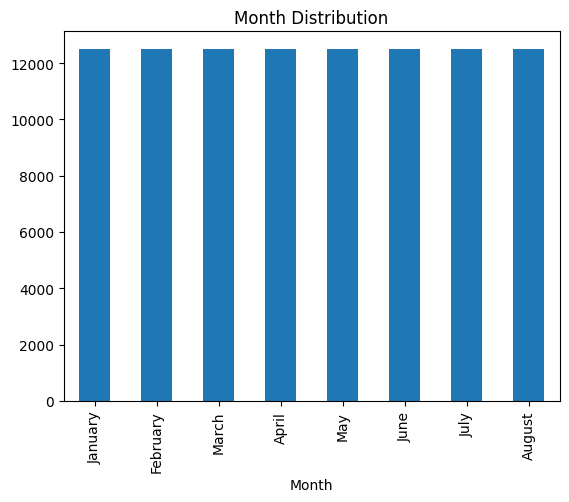

In [24]:
month_plot = df['Month'].value_counts().plot(kind='bar', title='Month Distribution')

Преобразуем колонку с месяцами с помощью циклического кодирования признаков (https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning)

In [25]:
month_map = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12}

In [26]:
df_converted = pandas.DataFrame()

In [27]:
df_converted['month_sin'] = np.sin(2 * np.pi * df['Month'].map(month_map) / 12)
df_converted['month_cos'] = np.cos(2 * np.pi * df['Month'].map(month_map) / 12)

2. Age

In [28]:
describe_column(df['Age'])

Column: Age
Data Type: object
Missing Values: 0
Unique Values: 1788
Statistical Summary:
count     100000
unique      1788
top           38
freq        2833
Name: Age, dtype: object


Age
38      2833
28      2829
31      2806
26      2792
32      2749
        ... 
6618       1
3155       1
5063       1
2875       1
4347       1
Name: count, Length: 1788, dtype: int64


Видно, что различных значений для Age слишком много (целых 1788), это значит, что есть большое кол-во опечаток, неверных значений или ошибок, так как должно их быть меньше 100 (+-).

In [29]:
age_converted = df['Age'].fillna('0').str.extract(r'(\d+)').astype(float).astype('int')

In [30]:
df_converted['age'] = age_converted

3. Occupation - род занятия человека

In [31]:
describe_column(df['Occupation'])

Column: Occupation
Data Type: object
Missing Values: 0
Unique Values: 16
Statistical Summary:
count      100000
unique         16
top       _______
freq         7062
Name: Occupation, dtype: object


Occupation
_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: count, dtype: int64


In [32]:
occupation = df['Occupation'].replace('_______', np.nan)

In [33]:
describe_column(occupation)

Column: Occupation
Data Type: object
Missing Values: 7062
Unique Values: 15
Statistical Summary:
count      92938
unique        15
top       Lawyer
freq        6575
Name: Occupation, dtype: object


Occupation
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: count, dtype: int64


In [34]:
occupation_converted = pandas.get_dummies(occupation, prefix='occ', dummy_na=True, dtype=int)

In [35]:
df_converted = pandas.concat([df_converted, occupation_converted], axis=1)

In [36]:
df_converted.head().T

0          1             2          3          4
month_sin           0.500000   0.866025  1.000000e+00   0.866025   0.500000
month_cos           0.866025   0.500000  6.123234e-17  -0.500000  -0.866025
age                23.000000  23.000000  5.000000e+02  23.000000  23.000000
occ_Accountant      0.000000   0.000000  0.000000e+00   0.000000   0.000000
occ_Architect       0.000000   0.000000  0.000000e+00   0.000000   0.000000
occ_Developer       0.000000   0.000000  0.000000e+00   0.000000   0.000000
occ_Doctor          0.000000   0.000000  0.000000e+00   0.000000   0.000000
occ_Engineer        0.000000   0.000000  0.000000e+00   0.000000   0.000000
occ_Entrepreneur    0.000000   0.000000  0.000000e+00   0.000000   0.000000
occ_Journalist      0.000000   0.000000  0.000000e+00   0.000000   0.000000
occ_Lawyer          0.000000   0.000000  0.000000e+00   0.000000   0.000000
occ_Manager         0.000000   0.000000  0.000000e+00   0.000000   0.000000
occ_Mechanic        0.000000   0.000000  0.000000e+00   0.000000   0.000000
occ_Media_Manager   0.000000   0.000000  0.000000e+00   0.000000   0.000000
occ_Musician        0.000000   0.000000  0.000000e+00   0.000000   0.000000
occ_Scientist       1.000000   1.000000  1.000000e+00   1.000000   1.000000
occ_Teacher         0.000000   0.000000  0.000000e+00   0.000000   0.000000
occ_Writer          0.000000   0.000000  0.000000e+00   0.000000   0.000000
occ_nan             0.000000   0.000000  0.000000e+00   0.000000   0.000000

4. Annual_Income - годовой доход человека

In [37]:
describe_column(df['Annual_Income'])

Column: Annual_Income
Data Type: object
Missing Values: 0
Unique Values: 18940
Statistical Summary:
count       100000
unique       18940
top       17273.83
freq            16
Name: Annual_Income, dtype: object


Annual_Income
17273.83      16
20867.67      16
36585.12      16
9141.63       15
95596.35      15
              ..
48706.1_       1
108484.38_     1
14855994.0     1
54392.16_      1
34081.38_      1
Name: count, Length: 18940, dtype: int64


In [38]:
annual_income_converted = df['Annual_Income'].str.replace(r'[^0-9.]', '', regex=True).astype(float)

In [39]:
df_converted['annual_income'] = annual_income_converted

5. Monthly_Inhand_Salary - ежемесячная базовая заработная плата человека 

In [40]:
describe_column(df['Monthly_Inhand_Salary'])

Column: Monthly_Inhand_Salary
Data Type: float64
Missing Values: 15002
Unique Values: 13235
Statistical Summary:
count    84998.000000
mean      4194.170850
std       3183.686167
min        303.645417
25%       1625.568229
50%       3093.745000
75%       5957.448333
max      15204.633333
Name: Monthly_Inhand_Salary, dtype: float64


Monthly_Inhand_Salary
6769.130000    15
6082.187500    15
6358.956667    15
2295.058333    15
3080.555000    14
               ..
3415.781667     1
6272.739429     1
1069.950000     1
454.382083      1
2319.831269     1
Name: count, Length: 13235, dtype: int64


In [41]:
df_converted['monthly_inhand_salary'] = df['Monthly_Inhand_Salary']

6. Num_Bank_Accounts - представляет собой количество банковских счетов, которые имеет человек

In [42]:
describe_column(df['Num_Bank_Accounts'])

Column: Num_Bank_Accounts
Data Type: int64
Missing Values: 0
Unique Values: 943
Statistical Summary:
count    100000.000000
mean         17.091280
std         117.404834
min          -1.000000
25%           3.000000
50%           6.000000
75%           7.000000
max        1798.000000
Name: Num_Bank_Accounts, dtype: float64


Num_Bank_Accounts
6       13001
7       12823
8       12765
4       12186
5       12118
        ...  
1091        1
1123        1
1657        1
299         1
1240        1
Name: count, Length: 943, dtype: int64


In [43]:
df_converted['num_bank_accounts'] = df['Num_Bank_Accounts']

7. Num_Credit_Card - представляет собой количество других кредитных карт, имеющихся у человека

In [44]:
describe_column(df["Num_Credit_Card"])

Column: Num_Credit_Card
Data Type: int64
Missing Values: 0
Unique Values: 1179
Statistical Summary:
count    100000.00000
mean         22.47443
std         129.05741
min           0.00000
25%           4.00000
50%           5.00000
75%           7.00000
max        1499.00000
Name: Num_Credit_Card, dtype: float64


Num_Credit_Card
5       18459
7       16615
6       16559
4       14030
3       13277
        ...  
1405        1
708         1
62          1
343         1
481         1
Name: count, Length: 1179, dtype: int64


In [45]:
df_converted['num_credit_cards'] = df["Num_Credit_Card"]

8. Interest_Rate - представляет собой процентную ставку по кредитной карте

In [46]:
describe_column(df['Interest_Rate'])

Column: Interest_Rate
Data Type: int64
Missing Values: 0
Unique Values: 1750
Statistical Summary:
count    100000.000000
mean         72.466040
std         466.422621
min           1.000000
25%           8.000000
50%          13.000000
75%          20.000000
max        5797.000000
Name: Interest_Rate, dtype: float64


Interest_Rate
8       5012
5       4979
6       4721
12      4540
10      4540
        ... 
3085       1
159        1
375        1
3177       1
3032       1
Name: count, Length: 1750, dtype: int64


In [47]:
df_converted['interest_rate'] = df['Interest_Rate']

9. Num_of_Loan - представляет собой количество кредитов, взятых в банке 

In [48]:
describe_column(df['Num_of_Loan'])

Column: Num_of_Loan
Data Type: object
Missing Values: 0
Unique Values: 434
Statistical Summary:
count     100000
unique       434
top            3
freq       14386
Name: Num_of_Loan, dtype: object


Num_of_Loan
3      14386
2      14250
4      14016
0      10380
1      10083
       ...  
41         1
18         1
56         1
657        1
917        1
Name: count, Length: 434, dtype: int64


In [49]:
df_converted['num_of_loan'] = df['Num_of_Loan'].str.replace(r'[^0-9]', '', regex=True).astype(int)

10. Type_of_Loan - представляет собой типы кредитов, взятых лицом 

In [50]:
describe_column(df['Type_of_Loan'])

Column: Type_of_Loan
Data Type: object
Missing Values: 11408
Unique Values: 6260
Statistical Summary:
count             88592
unique             6260
top       Not Specified
freq               1408
Name: Type_of_Loan, dtype: object


Type_of_Loan
Not Specified                                                                                        1408
Credit-Builder Loan                                                                                  1280
Personal Loan                                                                                        1272
Debt Consolidation Loan                                                                              1264
Student Loan                                                                                         1240
                                                                                                     ... 
Auto Loan, Payday Loan, Auto Loan, Student Loan, Student Loan, Student Loan, and Home Equity Loan       8
Home Equity

In [51]:
counter = 0
unexpected_types = set()
loan_types = ["Not Specified", "Credit-Builder Loan", "Personal Loan", "Debt Consolidation Loan", "Student Loan", "Auto Loan", "Home Equity Loan", "Payday Loan", "Mortgage Loan"]
for loan_type in df['Type_of_Loan']:
    is_find = False
    for expected_type in loan_types:
        if expected_type in str(loan_type):
            is_find = True
            break
    if is_find == False:
        print(f"Unexpected loan type: {loan_type}")
        unexpected_types.add(loan_type)
        counter += 1

print(f"Total unexpected loan types: {counter}")
print("Unexpected types found:", unexpected_types)

Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected loan type: nan
Unexpected l

Теперь стобец сторк необходимо во что-то преобразовать (https://celik-muhammed.medium.com/how-to-converting-pandas-column-of-comma-separated-strings-into-dummy-variables-762c02282a6c)

In [52]:
mlb = sklearn.preprocessing.MultiLabelBinarizer()

loan_types_split = df['Type_of_Loan'].apply(
    lambda x: [s.strip() for part in str(x).split(',') for s in part.split(' and ') if s.strip()]
)

loan_encoded = mlb.fit_transform(loan_types_split)

print(mlb.classes_)

loan_df = pandas.DataFrame(loan_encoded, columns=mlb.classes_, index=df.index)

loan_df.rename(columns=lambda x: f'loan_type_{x.lower().replace(" ", "_").replace("-", "_")}', inplace=True)

print(loan_df.columns)

['Auto Loan' 'Credit-Builder Loan' 'Debt Consolidation Loan'
 'Home Equity Loan' 'Mortgage Loan' 'Not Specified' 'Payday Loan'
 'Personal Loan' 'Student Loan' 'nan']
Index(['loan_type_auto_loan', 'loan_type_credit_builder_loan',
       'loan_type_debt_consolidation_loan', 'loan_type_home_equity_loan',
       'loan_type_mortgage_loan', 'loan_type_not_specified',
       'loan_type_payday_loan', 'loan_type_personal_loan',
       'loan_type_student_loan', 'loan_type_nan'],
      dtype='object')


In [53]:
df_converted = pandas.concat([df_converted, loan_df], axis=1)

11. Delay_from_due_date - представляет собой среднее количество дней задержки с даты платежа

In [54]:
describe_column(df['Delay_from_due_date'])

Column: Delay_from_due_date
Data Type: int64
Missing Values: 0
Unique Values: 73
Statistical Summary:
count    100000.000000
mean         21.068780
std          14.860104
min          -5.000000
25%          10.000000
50%          18.000000
75%          28.000000
max          67.000000
Name: Delay_from_due_date, dtype: float64


Delay_from_due_date
 15    3596
 13    3424
 8     3324
 14    3313
 10    3281
       ... 
-4       62
 65      56
-5       33
 66      32
 67      22
Name: count, Length: 73, dtype: int64


In [55]:
df_converted["delay_from_due_date"] = df['Delay_from_due_date']

12. Num_of_Delayed_Payment - представляет собой среднее количество платежей, просроченных человеком

In [56]:
describe_column(df['Num_of_Delayed_Payment'])

Column: Num_of_Delayed_Payment
Data Type: object
Missing Values: 7002
Unique Values: 749
Statistical Summary:
count     92998
unique      749
top          19
freq       5327
Name: Num_of_Delayed_Payment, dtype: object


Num_of_Delayed_Payment
19      5327
17      5261
16      5173
10      5153
18      5083
        ... 
4037       1
1571       1
86         1
399        1
3827       1
Name: count, Length: 749, dtype: int64


In [57]:
num_of_delayed_payment_converted = df['Num_of_Delayed_Payment'].str.replace(r'[^0-9]', '', regex=True).astype(float)

In [58]:
df_converted['num_of_delayed_payment'] = num_of_delayed_payment_converted

13. Changed_Credit_Limit - представляет собой процентное изменение лимита кредитной карты

In [59]:
describe_column(df['Changed_Credit_Limit'])

Column: Changed_Credit_Limit
Data Type: object
Missing Values: 0
Unique Values: 4384
Statistical Summary:
count     100000
unique      4384
top            _
freq        2091
Name: Changed_Credit_Limit, dtype: object


Changed_Credit_Limit
_                    2091
8.22                  133
11.5                  127
11.32                 126
7.35                  121
                     ... 
30.16                   1
4.710000000000001       1
-4.39                   1
27.38                   1
16.63                   1
Name: count, Length: 4384, dtype: int64


In [60]:
changed_credit_limit_converted = df['Changed_Credit_Limit'].str.replace(r'[^0-9]', '', regex=True)
changed_credit_limit_converted = changed_credit_limit_converted.replace('', np.nan).astype(float)

In [61]:
df_converted['cnaged_credit_limit'] = changed_credit_limit_converted

14. Num_Credit_Inquiries - представляет количество запросов по кредитным картам

In [62]:
describe_column(df['Num_Credit_Inquiries'])

Column: Num_Credit_Inquiries
Data Type: float64
Missing Values: 1965
Unique Values: 1223
Statistical Summary:
count    98035.000000
mean        27.754251
std        193.177339
min          0.000000
25%          3.000000
50%          6.000000
75%          9.000000
max       2597.000000
Name: Num_Credit_Inquiries, dtype: float64


Num_Credit_Inquiries
4.0       11271
3.0        8890
6.0        8111
7.0        8058
2.0        8028
          ...  
1618.0        1
758.0         1
735.0         1
2483.0        1
1960.0        1
Name: count, Length: 1223, dtype: int64


In [63]:
df_converted['num_credit_inquiries'] = df['Num_Credit_Inquiries']

15. Credit_Mix - представляет собой классификацию набора кредитов

In [64]:
describe_column(df['Credit_Mix'])

Column: Credit_Mix
Data Type: object
Missing Values: 0
Unique Values: 4
Statistical Summary:
count       100000
unique           4
top       Standard
freq         36479
Name: Credit_Mix, dtype: object


Credit_Mix
Standard    36479
Good        24337
_           20195
Bad         18989
Name: count, dtype: int64


In [65]:
credit_mix_converted = df.Credit_Mix.replace("_", np.nan)
credit_mix_converted = pandas.get_dummies(credit_mix_converted, prefix='credit_mix', dummy_na=True, dtype=int)

In [66]:
df_converted = pandas.concat([df_converted, credit_mix_converted], axis=1)

16. Outstanding_Debt - представляет собой оставшуюся задолженность, подлежащую уплате (в долларах США)

In [67]:
describe_column(df['Outstanding_Debt'])

Column: Outstanding_Debt
Data Type: object
Missing Values: 0
Unique Values: 13178
Statistical Summary:
count      100000
unique      13178
top       1360.45
freq           24
Name: Outstanding_Debt, dtype: object


Outstanding_Debt
1360.45     24
460.46      23
1151.7      23
1109.03     23
482.88      16
            ..
494.51_      1
807.65_      1
290.39_      1
2866.5_      1
1283.37_     1
Name: count, Length: 13178, dtype: int64


In [68]:
outstanding_debt_converted = df['Outstanding_Debt'].str.replace(r'[^0-9.]', '', regex=True).astype(float)

In [69]:
df_converted['outstanding_debt'] = outstanding_debt_converted

17. Credit_Utilization_Ratio - представляет собой коэффициент использования кредитной карты

In [70]:
describe_column(df['Credit_History_Age'])

Column: Credit_History_Age
Data Type: object
Missing Values: 9030
Unique Values: 404
Statistical Summary:
count                      90970
unique                       404
top       15 Years and 11 Months
freq                         446
Name: Credit_History_Age, dtype: object


Credit_History_Age
15 Years and 11 Months    446
19 Years and 4 Months     445
19 Years and 5 Months     444
17 Years and 11 Months    443
19 Years and 3 Months     441
                         ... 
0 Years and 3 Months       20
0 Years and 2 Months       15
33 Years and 7 Months      14
33 Years and 8 Months      12
0 Years and 1 Months        2
Name: count, Length: 404, dtype: int64


In [71]:
credit_history_age = df.Credit_History_Age.apply(lambda x: int(x.split(' ')[0]) * 12 + int(x.split(' ')[3]) if pandas.notna(x) else np.nan)

In [72]:
describe_column(credit_history_age)

Column: Credit_History_Age
Data Type: float64
Missing Values: 9030
Unique Values: 404
Statistical Summary:
count    90970.000000
mean       221.195405
std         99.741364
min          1.000000
25%        144.000000
50%        219.000000
75%        302.000000
max        404.000000
Name: Credit_History_Age, dtype: float64


Credit_History_Age
191.0    446
232.0    445
233.0    444
215.0    443
231.0    441
        ... 
3.0       20
2.0       15
403.0     14
404.0     12
1.0        2
Name: count, Length: 404, dtype: int64


In [73]:
df_converted['credit_history_age'] = credit_history_age

18. Payment_of_Min_Amount - показывает, была ли оплачена лицом только минимальная сумма

In [74]:
describe_column(df['Payment_of_Min_Amount'])

Column: Payment_of_Min_Amount
Data Type: object
Missing Values: 0
Unique Values: 3
Statistical Summary:
count     100000
unique         3
top          Yes
freq       52326
Name: Payment_of_Min_Amount, dtype: object


Payment_of_Min_Amount
Yes    52326
No     35667
NM     12007
Name: count, dtype: int64


In [75]:
payment_of_min_amount_converted = df['Payment_of_Min_Amount'].map({'No': 0, 'Yes': 1, '_': np.nan})

In [76]:
describe_column(payment_of_min_amount_converted)

Column: Payment_of_Min_Amount
Data Type: float64
Missing Values: 12007
Unique Values: 2
Statistical Summary:
count    87993.000000
mean         0.594661
std          0.490960
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Payment_of_Min_Amount, dtype: float64


Payment_of_Min_Amount
1.0    52326
0.0    35667
Name: count, dtype: int64


In [77]:
df_converted['payment_of_min_amount'] = payment_of_min_amount_converted

19. Total_EMI_per_month - представляет собой ежемесячные платежи по EMI (в долларах США)

In [78]:
describe_column(df['Total_EMI_per_month'])

Column: Total_EMI_per_month
Data Type: float64
Missing Values: 0
Unique Values: 14950
Statistical Summary:
count    100000.000000
mean       1403.118217
std        8306.041270
min           0.000000
25%          30.306660
50%          69.249473
75%         161.224249
max       82331.000000
Name: Total_EMI_per_month, dtype: float64


Total_EMI_per_month
0.000000        10613
31.086195           8
149.897199          8
62.222285           8
171.430198          8
                ...  
33746.000000        1
39347.000000        1
27292.000000        1
16627.000000        1
49430.000000        1
Name: count, Length: 14950, dtype: int64


In [79]:
df_converted['total_emi_per_month'] = df['Total_EMI_per_month']

20. Amount_invested_monthly - представляет собой ежемесячную сумму инвестиций клиента (в долларах США)

In [80]:
describe_column(df['Amount_invested_monthly'])

Column: Amount_invested_monthly
Data Type: object
Missing Values: 4479
Unique Values: 91049
Statistical Summary:
count         95521
unique        91049
top       __10000__
freq           4305
Name: Amount_invested_monthly, dtype: object


Amount_invested_monthly
__10000__             4305
0.0                    169
167.1638651610451        1
80.41529543900253        1
118.28022162236736       1
                      ... 
215.48638555294247       1
78.49772657092517        1
147.33990786653956       1
82.82557214415213        1
42.935565846112745       1
Name: count, Length: 91049, dtype: int64


In [81]:
amount_invested_monthly_converted = df['Amount_invested_monthly'].replace("__10000__", np.nan)
amount_invested_monthly_converted = amount_invested_monthly_converted.str.replace(r'[^0-9.]', '', regex=True).astype(float)

In [82]:
describe_column(amount_invested_monthly_converted)

Column: Amount_invested_monthly
Data Type: float64
Missing Values: 8784
Unique Values: 91048
Statistical Summary:
count    91216.000000
mean       195.539456
std        199.564527
min          0.000000
25%         72.236692
50%        128.954538
75%        236.815814
max       1977.326102
Name: Amount_invested_monthly, dtype: float64


Amount_invested_monthly
0.000000      169
43.370670       1
42.935566       1
104.291825      1
167.163865      1
             ... 
215.486386      1
78.497727       1
147.339908      1
82.825572       1
124.881820      1
Name: count, Length: 91048, dtype: int64


In [83]:
df_converted['amount_invested_monthly'] = amount_invested_monthly_converted

21. Payment_Behaviour - представляет платежное поведение клиента (в долларах США)

In [84]:
describe_column(df['Payment_Behaviour'])

Column: Payment_Behaviour
Data Type: object
Missing Values: 0
Unique Values: 7
Statistical Summary:
count                             100000
unique                                 7
top       Low_spent_Small_value_payments
freq                               25513
Name: Payment_Behaviour, dtype: object


Payment_Behaviour
Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
!@9#%8                               7600
Name: count, dtype: int64


In [85]:
payment_behaviour_converted = df['Payment_Behaviour'].replace("!@9#%8", np.nan)

In [86]:
payment_behaviour_converted = pandas.get_dummies(payment_behaviour_converted, prefix='pay_beh', dummy_na=True, dtype=int)

In [87]:
print(payment_behaviour_converted)

       pay_beh_High_spent_Large_value_payments  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   
...                                        ...   
99995                                        1   
99996                                        0   
99997                                        1   
99998                                        0   
99999                                        0   

       pay_beh_High_spent_Medium_value_payments  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             1   
...                                         ...   
99995                                     

In [88]:
df_converted = pandas.concat([df_converted, payment_behaviour_converted], axis=1)

22. Monthly_Balance - представляет собой ежемесячный остаток на счете клиента (в долларах США)

In [89]:
describe_column(df['Monthly_Balance'])

Column: Monthly_Balance
Data Type: object
Missing Values: 1200
Unique Values: 98792
Statistical Summary:
count                                98800
unique                               98792
top       __-333333333333333333333333333__
freq                                     9
Name: Monthly_Balance, dtype: object


Monthly_Balance
__-333333333333333333333333333__    9
328.655224                          1
432.559318                          1
470.69062692529184                  1
393.673696                          1
                                   ..
300.008498                          1
396.997157                          1
368.154976                          1
412.669312                          1
895.494583180492                    1
Name: count, Length: 98792, dtype: int64


In [90]:
monthly_balance_converted = df['Monthly_Balance'].replace("__-333333333333333333333333333__", np.nan)
monthly_balance_converted = monthly_balance_converted.str.replace(r'[^0-9.-]', '', regex=True).astype(float)

In [91]:
df_converted['monthly_balance'] = monthly_balance_converted

In [92]:
df_converted.describe().T

count          mean  \
month_sin                                 100000.0  2.957532e-01   
month_cos                                 100000.0 -2.957532e-01   
age                                       100000.0  1.195097e+02   
occ_Accountant                            100000.0  6.271000e-02   
occ_Architect                             100000.0  6.355000e-02   
occ_Developer                             100000.0  6.235000e-02   
occ_Doctor                                100000.0  6.087000e-02   
occ_Engineer                              100000.0  6.350000e-02   
occ_Entrepreneur                          100000.0  6.174000e-02   
occ_Journalist                            100000.0  6.085000e-02   
occ_Lawyer                                100000.0  6.575000e-02   
occ_Manager                               100000.0  5.973000e-02   
occ_Mechanic                              100000.0  6.291000e-02   
occ_Media_Manager                         100000.0  6.232000e-02   
occ_Musician                              100000.0  5.911000e-02   
occ_Scientist                             100000.0  6.299000e-02   
occ_Teacher                               100000.0  6.215000e-02   
occ_Writer                                100000.0  5.885000e-02   
occ_nan                                   100000.0  7.062000e-02   
annual_income                             100000.0  1.764157e+05   
monthly_inhand_salary                      84998.0  4.194171e+03   
num_bank_accounts                         100000.0  1.709128e+01   
num_credit_cards                          100000.0  2.247443e+01   
interest_rate                             100000.0  7.246604e+01   
num_of_loan                               100000.0  1.076196e+01   
loan_type_auto_loan                       100000.0  3.056000e-01   
loan_type_credit_builder_loan             100000.0  3.172800e-01   
loan_type_debt_consolidation_loan         100000.0  3.104000e-01   
loan_type_home_equity_loan                100000.0  3.140000e-01   
loan_type_mortgage_loan                   100000.0  3.136000e-01   
loan_type_not_specified                   100000.0  3.168000e-01   
loan_type_payday_loan                     100000.0  3.194400e-01   
loan_type_personal_loan                   100000.0  3.110400e-01   
loan_type_student_loan                    100000.0  3.104000e-01   
loan_type_nan                             100000.0  1.140800e-01   
delay_from_due_date                       100000.0  2.106878e+01   
num_of_delayed_payment                     92998.0  3.094627e+01   
cnaged_credit_limit                        97909.0  6.304669e+14   
num_credit_inquiries                       98035.0  2.775425e+01   
credit_mix_Bad                            100000.0  1.898900e-01   
credit_mix_Good                           100000.0  2.433700e-01   
credit_mix_Standard                       100000.0  3.647900e-01   
credit_mix_nan                            100000.0  2.019500e-01   
outstanding_debt                          100000.0  1.426220e+03   
credit_history_age                         90970.0  2.211954e+02   
payment_of_min_amount                      87993.0  5.946609e-01   
total_emi_per_month                       100000.0  1.403118e+03   
amount_invested_monthly                    91216.0  1.955395e+02   
pay_beh_High_spent_Large_value_payments   100000.0  1.372100e-01   
pay_beh_High_spent_Medium_value_payments  100000.0  1.754000e-01   
pay_beh_High_spent_Small_value_payments   100000.0  1.134000e-01   
pay_beh_Low_spent_Large_value_payments    100000.0  1.042500e-01   
pay_beh_Low_spent_Medium_value_payments   100000.0  1.386100e-01   
pay_beh_Low_spent_Small_value_payments    100000.0  2.551300e-01   
pay_beh_nan                               100000.0  7.600000e-02   
monthly_balance                            97123.0  4.021645e+02   

                                                   std          min  \
month_sin                                 6.422882e-01    -0.866025   
month_cos                 

23. Credit_Utilization_Ratio - представляет собой коэффициент использования кредитной карты

In [93]:
describe_column(df['Credit_Utilization_Ratio'])

Column: Credit_Utilization_Ratio
Data Type: float64
Missing Values: 0
Unique Values: 100000
Statistical Summary:
count    100000.000000
mean         32.285173
std           5.116875
min          20.000000
25%          28.052567
50%          32.305784
75%          36.496663
max          50.000000
Name: Credit_Utilization_Ratio, dtype: float64


Credit_Utilization_Ratio
39.300980    1
38.850680    1
37.753013    1
27.495263    1
36.979007    1
            ..
24.797347    1
31.377862    1
28.609352    1
31.944960    1
26.822620    1
Name: count, Length: 100000, dtype: int64


In [94]:
df_converted['credit_utilization_ratio'] = df['Credit_Utilization_Ratio']

24. Credit_Score - представляет собой диапазон кредитного рейтинга (плохой, стандартный, хороший)

In [95]:
describe_column(df["Credit_Score"])

Column: Credit_Score
Data Type: object
Missing Values: 0
Unique Values: 3
Statistical Summary:
count       100000
unique           3
top       Standard
freq         53174
Name: Credit_Score, dtype: object


Credit_Score
Standard    53174
Poor        28998
Good        17828
Name: count, dtype: int64


In [96]:
df_converted = pandas.concat([df_converted, df['Credit_Score'].map({'Poor': 0, 'Standard': 1, 'Good': 2})], axis=1)

Те ячейки, в которых не может быть отрицательных значений - заменим на np.nan

In [97]:
for column in df_converted.columns:
    print(f"Column name: {column}")
    print(f"Min value: {df_converted[column].min()}")

Column name: month_sin
Min value: -0.8660254037844385
Column name: month_cos
Min value: -1.0
Column name: age
Min value: 14
Column name: occ_Accountant
Min value: 0
Column name: occ_Architect
Min value: 0
Column name: occ_Developer
Min value: 0
Column name: occ_Doctor
Min value: 0
Column name: occ_Engineer
Min value: 0
Column name: occ_Entrepreneur
Min value: 0
Column name: occ_Journalist
Min value: 0
Column name: occ_Lawyer
Min value: 0
Column name: occ_Manager
Min value: 0
Column name: occ_Mechanic
Min value: 0
Column name: occ_Media_Manager
Min value: 0
Column name: occ_Musician
Min value: 0
Column name: occ_Scientist
Min value: 0
Column name: occ_Teacher
Min value: 0
Column name: occ_Writer
Min value: 0
Column name: occ_nan
Min value: 0
Column name: annual_income
Min value: 7005.93
Column name: monthly_inhand_salary
Min value: 303.6454166666666
Column name: num_bank_accounts
Min value: -1
Column name: num_credit_cards
Min value: 0
Column name: interest_rate
Min value: 1
Column name

In [98]:
only_positive_columns = [
    "age", 
    "annual_income", 
    "monthly_inhand_salary", 
    "num_bank_accounts", 
    "num_credit_cards", 
    "num_of_loan", 
    "num_of_delayed_payment", 
    "num_credit_inquiries", 
    "outstanding_debt", 
    "credit_history_age", 
    "total_emi_per_month", 
    "amount_invested_monthly", 
    "monthly_balance", 
    "credit_utilization_ratio"
]

In [99]:
for col in only_positive_columns:
    df_converted.loc[df_converted[col] < 0, col] = np.nan


In [100]:
len(df_converted)

100000

In [101]:
for column in only_positive_columns:
    print(f"Min value: {df_converted[column].min()}")

Min value: 14.0
Min value: 7005.93
Min value: 303.6454166666666
Min value: 0.0
Min value: 0.0
Min value: 0.0
Min value: 0.0
Min value: 0.0
Min value: 0.23
Min value: 1.0
Min value: 0.0
Min value: 0.0
Min value: 0.007759664775335295
Min value: 20.0


In [102]:
df_converted.describe().T

count          mean  \
month_sin                                 100000.0  2.957532e-01   
month_cos                                 100000.0 -2.957532e-01   
age                                       100000.0  1.195097e+02   
occ_Accountant                            100000.0  6.271000e-02   
occ_Architect                             100000.0  6.355000e-02   
occ_Developer                             100000.0  6.235000e-02   
occ_Doctor                                100000.0  6.087000e-02   
occ_Engineer                              100000.0  6.350000e-02   
occ_Entrepreneur                          100000.0  6.174000e-02   
occ_Journalist                            100000.0  6.085000e-02   
occ_Lawyer                                100000.0  6.575000e-02   
occ_Manager                               100000.0  5.973000e-02   
occ_Mechanic                              100000.0  6.291000e-02   
occ_Media_Manager                         100000.0  6.232000e-02   
occ_Musician                              100000.0  5.911000e-02   
occ_Scientist                             100000.0  6.299000e-02   
occ_Teacher                               100000.0  6.215000e-02   
occ_Writer                                100000.0  5.885000e-02   
occ_nan                                   100000.0  7.062000e-02   
annual_income                             100000.0  1.764157e+05   
monthly_inhand_salary                      84998.0  4.194171e+03   
num_bank_accounts                          99979.0  1.709508e+01   
num_credit_cards                          100000.0  2.247443e+01   
interest_rate                             100000.0  7.246604e+01   
num_of_loan                               100000.0  1.076196e+01   
loan_type_auto_loan                       100000.0  3.056000e-01   
loan_type_credit_builder_loan             100000.0  3.172800e-01   
loan_type_debt_consolidation_loan         100000.0  3.104000e-01   
loan_type_home_equity_loan                100000.0  3.140000e-01   
loan_type_mortgage_loan                   100000.0  3.136000e-01   
loan_type_not_specified                   100000.0  3.168000e-01   
loan_type_payday_loan                     100000.0  3.194400e-01   
loan_type_personal_loan                   100000.0  3.110400e-01   
loan_type_student_loan                    100000.0  3.104000e-01   
loan_type_nan                             100000.0  1.140800e-01   
delay_from_due_date                       100000.0  2.106878e+01   
num_of_delayed_payment                     92998.0  3.094627e+01   
cnaged_credit_limit                        97909.0  6.304669e+14   
num_credit_inquiries                       98035.0  2.775425e+01   
credit_mix_Bad                            100000.0  1.898900e-01   
credit_mix_Good                           100000.0  2.433700e-01   
credit_mix_Standard                       100000.0  3.647900e-01   
credit_mix_nan                            100000.0  2.019500e-01   
outstanding_debt                          100000.0  1.426220e+03   
credit_history_age                         90970.0  2.211954e+02   
payment_of_min_amount                      87993.0  5.946609e-01   
total_emi_per_month                       100000.0  1.403118e+03   
amount_invested_monthly                    91216.0  1.955395e+02   
pay_beh_High_spent_Large_value_payments   100000.0  1.372100e-01   
pay_beh_High_spent_Medium_value_payments  100000.0  1.754000e-01   
pay_beh_High_spent_Small_value_payments   100000.0  1.134000e-01   
pay_beh_Low_spent_Large_value_payments    100000.0  1.042500e-01   
pay_beh_Low_spent_Medium_value_payments   100000.0  1.386100e-01   
pay_beh_Low_spent_Small_value_payments    100000.0  2.551300e-01   
pay_beh_nan                               100000.0  7.600000e-02   
monthly_balance                            97123.0  4.021645e+02   
credit_utilization_ratio                  100000.0  3.228517e+01   
Credit_Score                              100000.0  8.883000e-01   

                                

Начнем избавляться от выбросов и некорректных данных

1. Age (Не вижу смысла удалять строки, у которых значения больше перцентеля 0.97, поэтому просто заменим их на median)

In [103]:
describe_column(df_converted.age)

Column: age
Data Type: float64
Missing Values: 0
Unique Values: 1728
Statistical Summary:
count    100000.000000
mean        119.509700
std         684.757313
min          14.000000
25%          25.000000
50%          34.000000
75%          42.000000
max        8698.000000
Name: age, dtype: float64


age
38.0      2994
28.0      2968
31.0      2955
26.0      2945
32.0      2884
          ... 
2406.0       1
5798.0       1
8490.0       1
1070.0       1
4402.0       1
Name: count, Length: 1728, dtype: int64


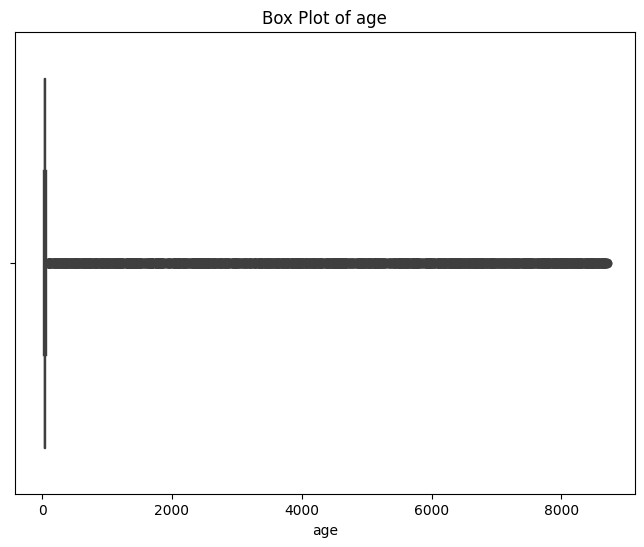

In [104]:
show_box_plot(df_converted, ['age'])

Before removed len: 100000
Quantile 0.97 = 56.0
count    100000.00000
mean         33.31111
std          10.61888
min          14.00000
25%          25.00000
50%          33.00000
75%          41.00000
max          56.00000
Name: age, dtype: float64
After replace len: 100000
Count of NaN before cleaning: 0


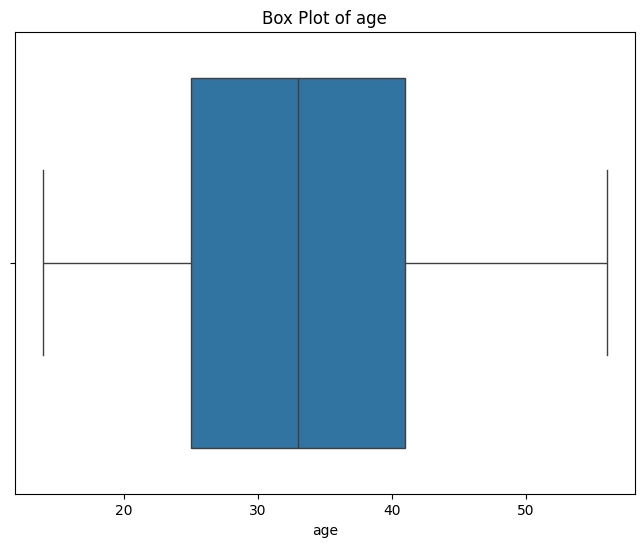

In [105]:
quantile_value = 0.97

print(f"Before removed len: {len(df_converted)}")

age_converted_quantile = df_converted.age.quantile(quantile_value)

print(f"Quantile {quantile_value} = {age_converted_quantile}")

df_converted.loc[df_converted['age'] > age_converted_quantile, 'age'] = np.nan

df_converted.age = df_converted.age.fillna(df_converted.age.median())

print(df_converted.age.describe())

print(f"After replace len: {len(df_converted)}")

print(f"Count of NaN before cleaning: {df_converted.age.isna().sum()}")

show_box_plot(df_converted, ['age'])

2. Рассмотрим колонки с 
'occ_Accountant', 'occ_Architect', 'occ_Developer', 'occ_Doctor', 'occ_Engineer', 'occ_Entrepreneur', 'occ_Journalist', 'occ_Lawyer', 'occ_Manager', 'occ_Mechanic', 'occ_Media_Manager', 'occ_Musician', 'occ_Scientist', 'occ_Teacher', 'occ_Writer', 'occ_nan'

In [106]:
# конкретно кол-во проущенных значений - число ячеек, где occ_nan[i] == 1

print(len(df_converted[df_converted['occ_nan'] == 1]))

df_converted.groupby('occ_nan')['Credit_Score'].mean()

# оставим эту колонку для дальнейшего анализа, пусть модель сама решает, нужна ли она или нет

7062


occ_nan
0    0.888291
1    0.888417
Name: Credit_Score, dtype: float64

3. Рассмотрим 'annual_income' - Represents the annual income of the person (Представляет собой годовой доход человека)

Column: annual_income
Data Type: float64
Missing Values: 0
Unique Values: 13487
Statistical Summary:
count    1.000000e+05
mean     1.764157e+05
std      1.429618e+06
min      7.005930e+03
25%      1.945750e+04
50%      3.757861e+04
75%      7.279092e+04
max      2.419806e+07
Name: annual_income, dtype: float64


annual_income
17273.83       16
17816.75       16
40341.16       16
9141.63        16
109945.32      16
               ..
6515990.00      1
10152115.00     1
586359.00       1
10909427.00     1
436443.00       1
Name: count, Length: 13487, dtype: int64


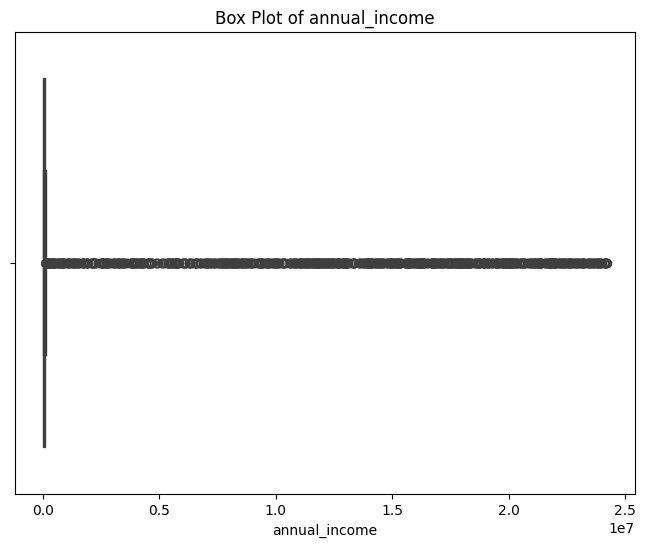

In [107]:
describe_column(df_converted.annual_income)
show_box_plot(df_converted, ['annual_income'])

Before removed len: 100000
Quantile 0.95 = 134533.32
After remove len: 95003


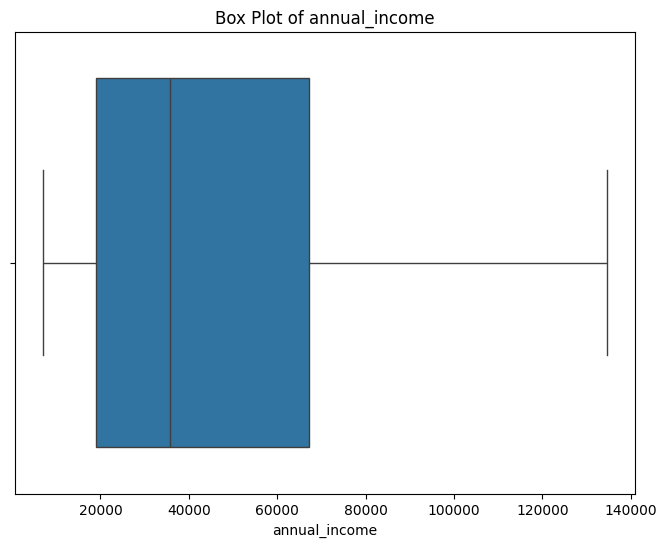

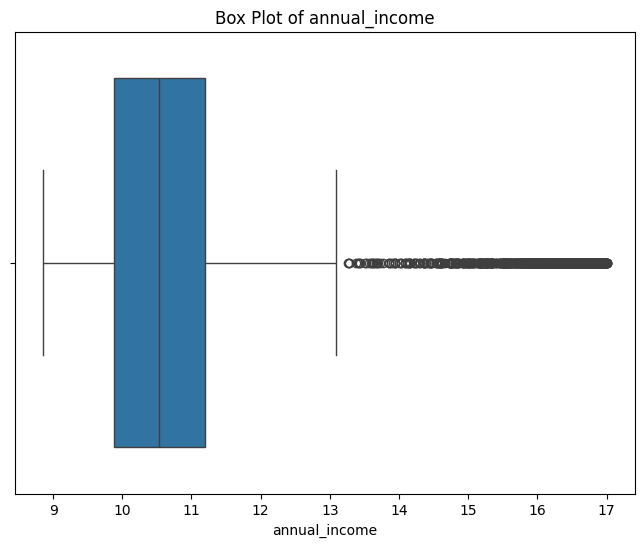

39673        7005.93
39672        7005.93
39677        7005.93
39676        7005.93
39675        7005.93
            ...     
27262    24105369.00
14588    24160009.00
59059    24177153.00
7814     24188807.00
48302    24198062.00
Name: annual_income, Length: 100000, dtype: float64
0


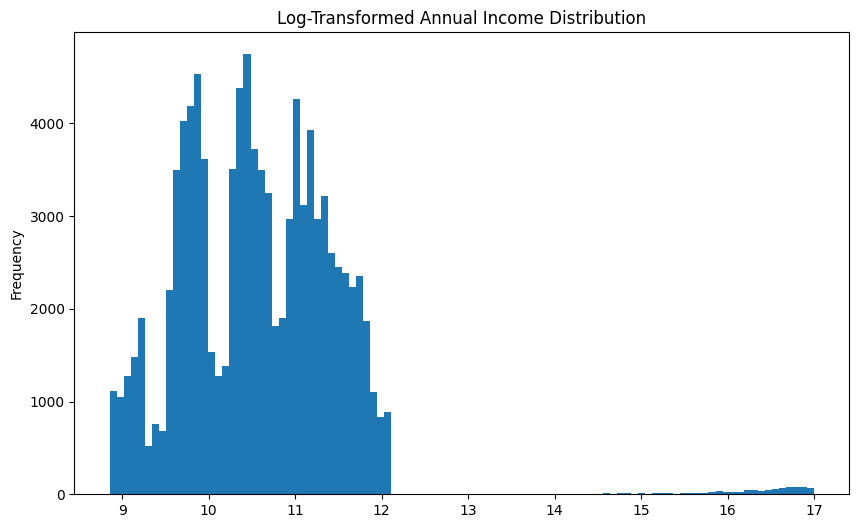

In [108]:
percentile_value_annual_income = 0.95

print(f"Before removed len: {len(df_converted)}")

temp = df_converted.annual_income.quantile(percentile_value_annual_income)

print(f"Quantile {percentile_value_annual_income} = {temp}")

temp = df_converted.annual_income[df_converted.annual_income <= temp]

print(f"After remove len: {len(temp)}")

show_box_plot(temp.to_frame(), ['annual_income'])

temp = np.log1p(df_converted.annual_income)

show_box_plot(temp.to_frame(), ['annual_income'])

np.log1p(df_converted['annual_income']).plot(kind='hist', bins=100, figsize=(10, 6), title='Log-Transformed Annual Income Distribution')

print(df_converted.annual_income.sort_values())
print(df_converted.annual_income.isna().sum())

In [109]:
df_converted.annual_income = np.log1p(df_converted['annual_income'])

4. 'monthly_inhand_salary' - Represents the monthly base salary of a person (Представляет собой ежемесячную базовую заработную плату человека)

In [110]:
describe_column(df_converted.monthly_inhand_salary)
print(f"Min value: {df_converted.monthly_inhand_salary.min()}")
print(df_converted.monthly_inhand_salary.dropna().sort_values().head(10))
print(df_converted.monthly_inhand_salary.dropna().sort_values().tail(50))

Column: monthly_inhand_salary
Data Type: float64
Missing Values: 15002
Unique Values: 13235
Statistical Summary:
count    84998.000000
mean      4194.170850
std       3183.686167
min        303.645417
25%       1625.568229
50%       3093.745000
75%       5957.448333
max      15204.633333
Name: monthly_inhand_salary, dtype: float64


monthly_inhand_salary
6769.130000    15
6082.187500    15
6358.956667    15
2295.058333    15
3080.555000    14
               ..
3415.781667     1
6272.739429     1
1069.950000     1
454.382083      1
2319.831269     1
Name: count, Length: 13235, dtype: int64
Min value: 303.6454166666666
83640    303.645417
83647    303.645417
83646    303.645417
83645    303.645417
83644    303.645417
83643    303.645417
83642    303.645417
83641    303.645417
41420    319.556250
41421    319.556250
Name: monthly_inhand_salary, dtype: float64
74784    15066.783333
68007    15090.076667
68003    15090.076667
68005    15090.076667
68004    15090.076667
68002    15090.076667

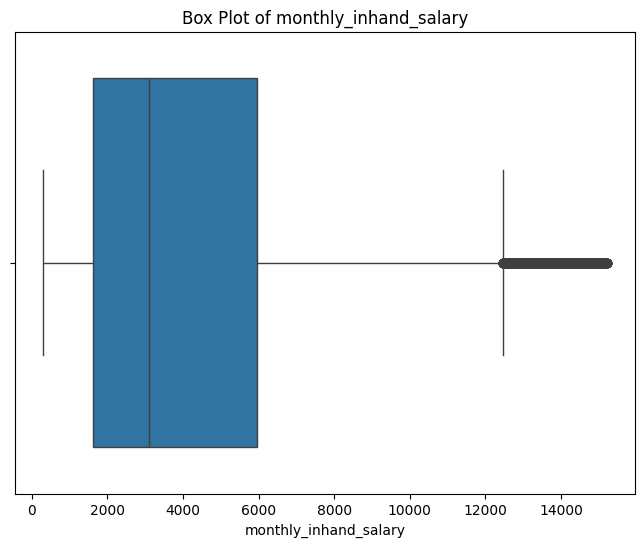

In [111]:
show_box_plot(df_converted, ['monthly_inhand_salary'])

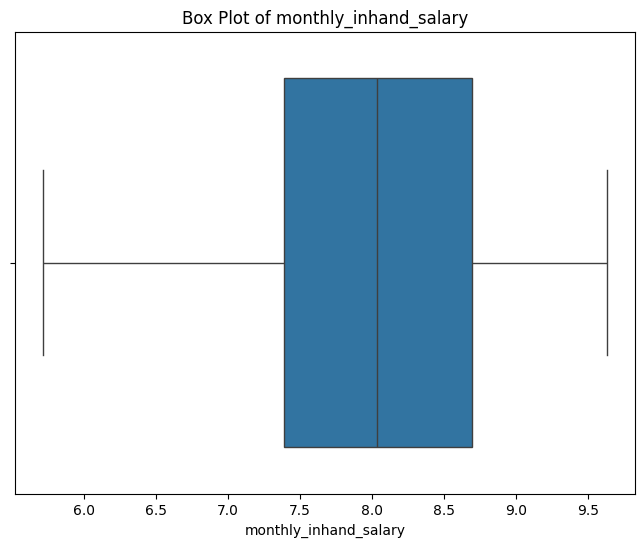

monthly_inhand_salary    15002
dtype: int64


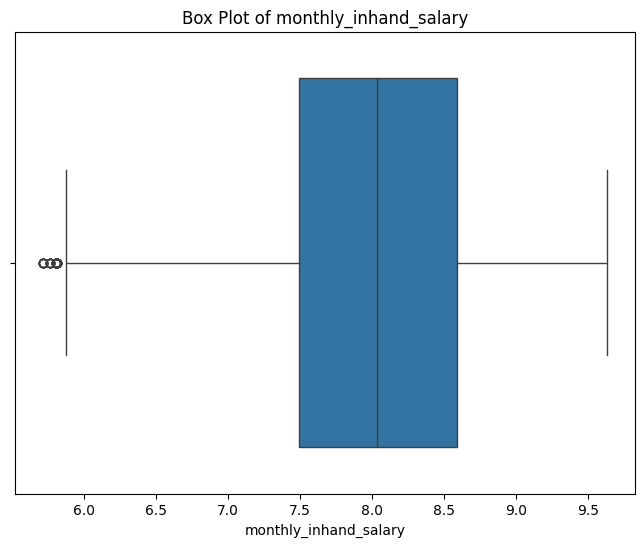

In [112]:
monthly_inhand_salary_log = np.log1p(df_converted.monthly_inhand_salary)

show_box_plot(monthly_inhand_salary_log.to_frame(), ['monthly_inhand_salary'])

print(monthly_inhand_salary_log.to_frame().isna().sum())

monthly_inhand_salary_log = monthly_inhand_salary_log.fillna(monthly_inhand_salary_log.median())
show_box_plot(monthly_inhand_salary_log.to_frame(), ['monthly_inhand_salary'])

In [113]:
df_converted.monthly_inhand_salary = monthly_inhand_salary_log

5. 'num_bank_accounts'

Column: num_bank_accounts
Data Type: float64
Missing Values: 21
Unique Values: 942
Statistical Summary:
count    99979.000000
mean        17.095080
std        117.416871
min          0.000000
25%          3.000000
50%          6.000000
75%          7.000000
max       1798.000000
Name: num_bank_accounts, dtype: float64


num_bank_accounts
6.0       13001
7.0       12823
8.0       12765
4.0       12186
5.0       12118
          ...  
1091.0        1
1123.0        1
1657.0        1
299.0         1
1240.0        1
Name: count, Length: 942, dtype: int64
0.0


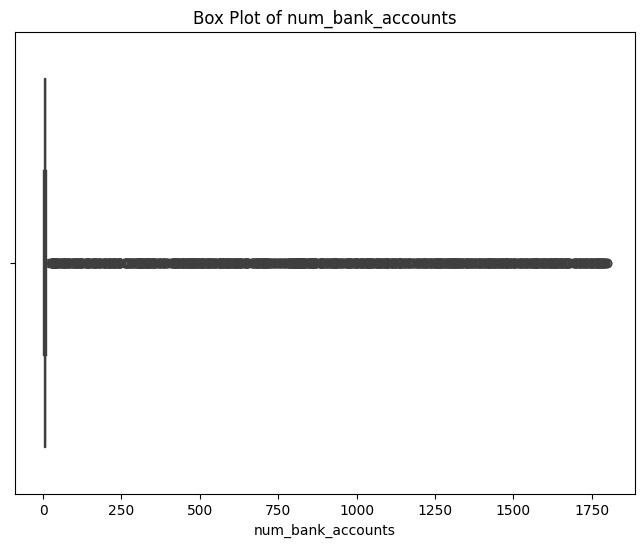

In [114]:
describe_column(df_converted.num_bank_accounts)
print(df_converted.num_bank_accounts.min())

show_box_plot(df_converted, ['num_bank_accounts'])

count    98655.000000
mean         5.368466
std          2.592011
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: num_bank_accounts, dtype: float64
1324
76447    11.0
76446    11.0
76445    11.0
76444    11.0
96822    11.0
96823    11.0
96820    11.0
96821    11.0
85959    11.0
73219    18.0
12447    26.0
95861    27.0
55871    28.0
18124    28.0
69723    28.0
58356    29.0
57421    30.0
21388    31.0
35688    32.0
89822    33.0
60908    33.0
78080    34.0
48188    34.0
97150    34.0
63133    34.0
59821    35.0
76978    37.0
1748     37.0
21722    37.0
6158     38.0
69065    39.0
78536    39.0
61504    39.0
69488    40.0
23522    41.0
37523    42.0
80808    42.0
64193    43.0
86739    43.0
22859    43.0
69155    43.0
11093    45.0
58660    49.0
54223    50.0
50887    53.0
22504    55.0
60935    57.0
98025    57.0
26092    59.0
17576    60.0
Name: num_bank_accounts, dtype: float64


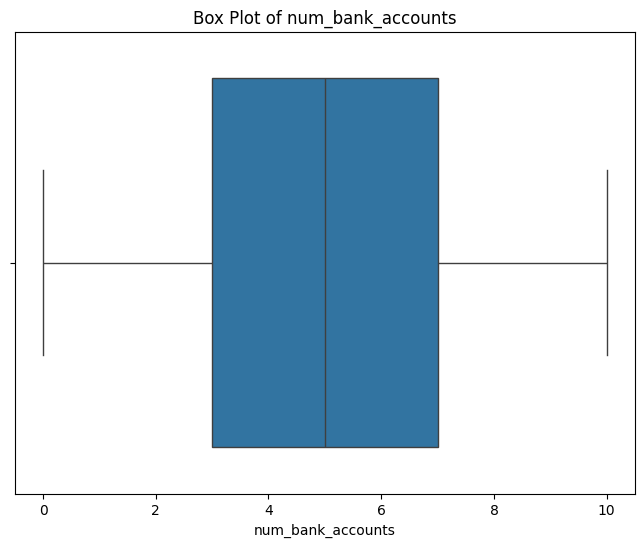

In [115]:
num_bank_accounts_quantile_value = 0.98

num_bank_accounts_quantile_values = df_converted.num_bank_accounts.quantile(num_bank_accounts_quantile_value)

num_bank_accounts_temp = df_converted.num_bank_accounts[df_converted.num_bank_accounts <= num_bank_accounts_quantile_values]

print(num_bank_accounts_temp.describe())
print(len(df_converted.num_bank_accounts[df_converted.num_bank_accounts > num_bank_accounts_quantile_values]))
print(df_converted.num_bank_accounts[df_converted.num_bank_accounts > num_bank_accounts_quantile_values].sort_values().head(50))

show_box_plot(num_bank_accounts_temp.to_frame(), ['num_bank_accounts'])

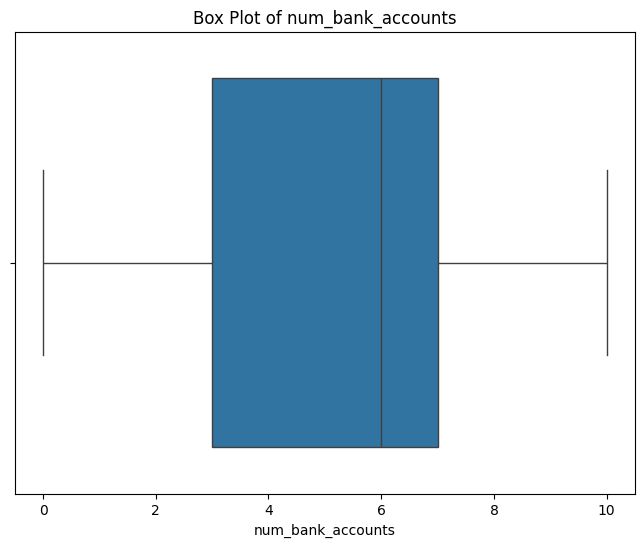

100000


In [116]:
df_converted['num_bank_accounts'] = df_converted['num_bank_accounts'].clip(upper=num_bank_accounts_quantile_values)
df_converted['num_bank_accounts'] = df_converted['num_bank_accounts'].clip(lower=0)
df_converted['num_bank_accounts'] = df_converted['num_bank_accounts'].fillna(df_converted['num_credit_cards'].median())

show_box_plot(df_converted, ['num_bank_accounts'])

print(len(df_converted))

6. 'num_credit_cards'

In [117]:
describe_column(df_converted.num_credit_cards)
print(df_converted.num_credit_cards.min())

Column: num_credit_cards
Data Type: float64
Missing Values: 0
Unique Values: 1179
Statistical Summary:
count    100000.00000
mean         22.47443
std         129.05741
min           0.00000
25%           4.00000
50%           5.00000
75%           7.00000
max        1499.00000
Name: num_credit_cards, dtype: float64


num_credit_cards
5.0       18459
7.0       16615
6.0       16559
4.0       14030
3.0       13277
          ...  
1405.0        1
708.0         1
62.0          1
343.0         1
481.0         1
Name: count, Length: 1179, dtype: int64
0.0


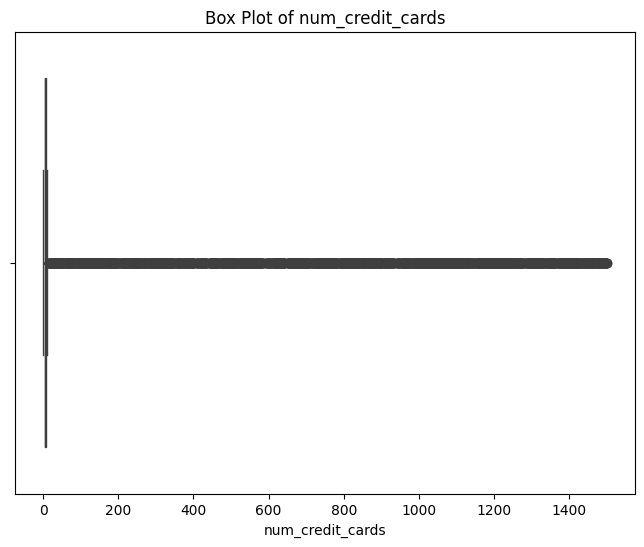

In [118]:
show_box_plot(df_converted, ['num_credit_cards'])

10.0


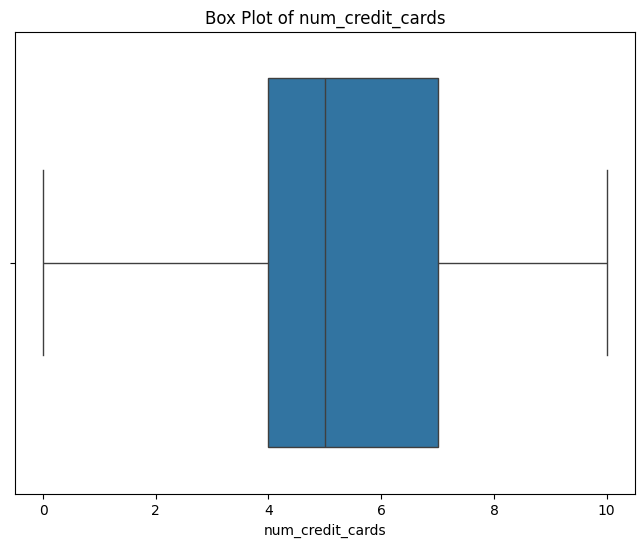

In [119]:
num_credit_cards_quantile_value = 0.97

num_credit_cards_quantile_values = df_converted.num_credit_cards.quantile(num_credit_cards_quantile_value)

print(num_credit_cards_quantile_values)

num_credit_cards_quantile = df_converted.num_credit_cards[df_converted.num_credit_cards <= num_credit_cards_quantile_values]

show_box_plot(num_credit_cards_quantile.to_frame(), ['num_credit_cards'])

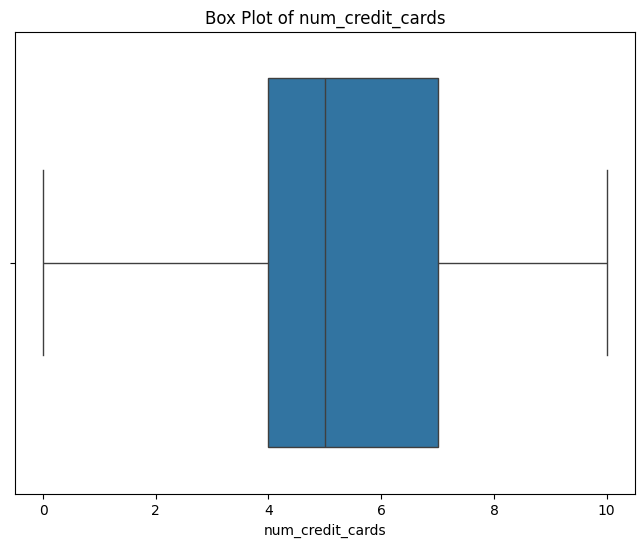

100000


In [120]:
df_converted['num_credit_cards'] = df_converted['num_credit_cards'].clip(upper=num_credit_cards_quantile_values)
df_converted['num_credit_cards'] = df_converted['num_credit_cards'].clip(lower=0)
df_converted['num_credit_cards'] = df_converted['num_credit_cards'].fillna(df_converted['num_credit_cards'].median())

show_box_plot(df_converted, ['num_credit_cards'])

print(len(df_converted))

7. 'interest_rate' - Represents the interest rate on credit card (Отражает процентную ставку по кредитной карте)

In [121]:
describe_column(df_converted.interest_rate)
print(df_converted.interest_rate.min())

Column: interest_rate
Data Type: int64
Missing Values: 0
Unique Values: 1750
Statistical Summary:
count    100000.000000
mean         72.466040
std         466.422621
min           1.000000
25%           8.000000
50%          13.000000
75%          20.000000
max        5797.000000
Name: interest_rate, dtype: float64


interest_rate
8       5012
5       4979
6       4721
12      4540
10      4540
        ... 
3085       1
159        1
375        1
3177       1
3032       1
Name: count, Length: 1750, dtype: int64
1


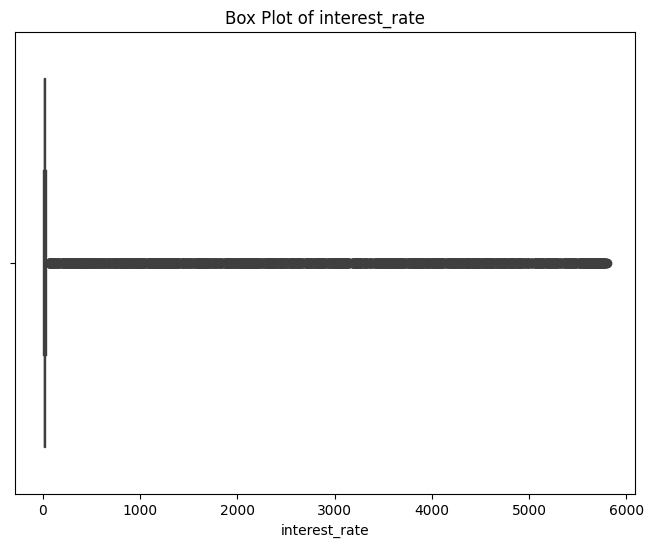

In [122]:
show_box_plot(df_converted, ['interest_rate'])

Value of quantile 0.97: 34.0
29078    34
96903    34
96902    34
96901    34
96900    34
94916    34
94915    34
94914    34
94913    34
94912    34
Name: interest_rate, dtype: int64


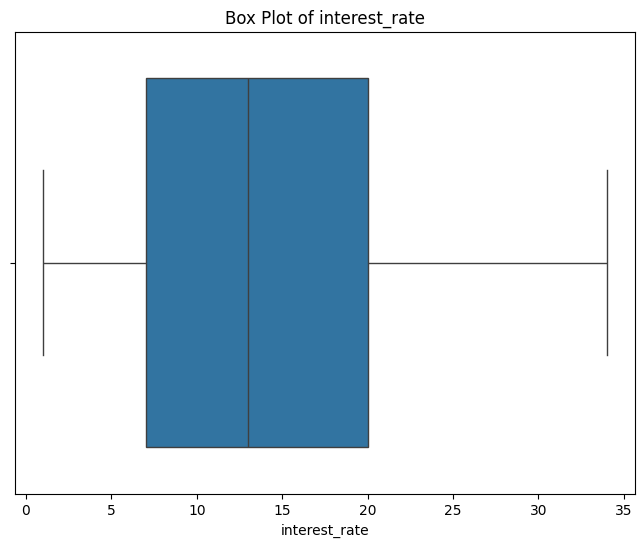

In [123]:
interes_rate_quantile = 0.97

interest_rate_quatile_value = df_converted.interest_rate.quantile(interes_rate_quantile)

print(f"Value of quantile {interes_rate_quantile}: {interest_rate_quatile_value}")

interest_rate_values = df_converted.interest_rate[df_converted.interest_rate <= interest_rate_quatile_value]

print(interest_rate_values.sort_values().tail(10))

show_box_plot(interest_rate_values.to_frame(), ['interest_rate'])

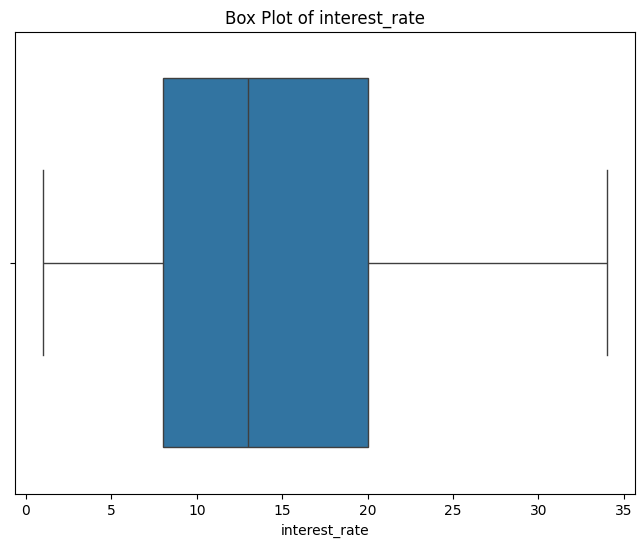

100000


In [124]:
df_converted['interest_rate'] = df_converted['interest_rate'].clip(upper=interest_rate_quatile_value)
df_converted['interest_rate'] = df_converted['interest_rate'].clip(lower=0)
df_converted['interest_rate'] = df_converted['interest_rate'].fillna(df_converted['interest_rate'].median())

show_box_plot(df_converted, ['interest_rate'])

print(len(df_converted))

8. 'num_of_loan'

Column: num_of_loan
Data Type: float64
Missing Values: 0
Unique Values: 413
Statistical Summary:
count    100000.000000
mean         10.761960
std          61.789933
min           0.000000
25%           2.000000
50%           3.000000
75%           6.000000
max        1496.000000
Name: num_of_loan, dtype: float64


num_of_loan
3.0       15104
2.0       15032
4.0       14743
0.0       10930
1.0       10606
          ...  
686.0         1
78.0          1
1400.0        1
136.0         1
504.0         1
Name: count, Length: 413, dtype: int64
0.0


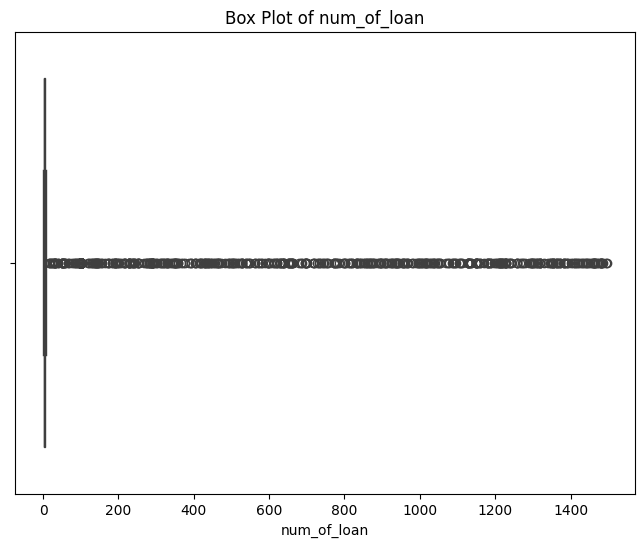

In [125]:
describe_column(df_converted.num_of_loan)
print(df_converted.num_of_loan.min())

show_box_plot(df_converted, ['num_of_loan'])

Value of quantile 0.95: 9.0
38651    9.0
22519    9.0
22518    9.0
22517    9.0
22516    9.0
22515    9.0
22514    9.0
54027    9.0
54026    9.0
38650    9.0
Name: num_of_loan, dtype: float64


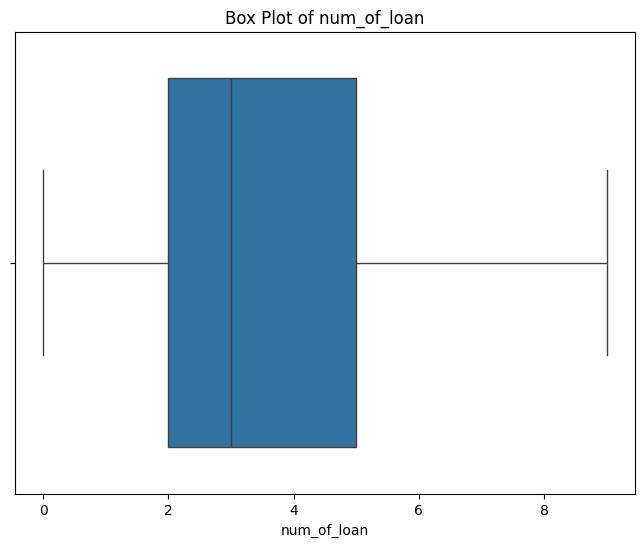

In [126]:
num_of_loan_quantile = 0.95

num_of_loan_quantile_value = df_converted.num_of_loan.quantile(num_of_loan_quantile)

print(f"Value of quantile {num_of_loan_quantile}: {num_of_loan_quantile_value}")

num_of_loan_quantile_values = df_converted.num_of_loan[df_converted.num_of_loan <= num_of_loan_quantile_value]

print(num_of_loan_quantile_values.sort_values().tail(10))

show_box_plot(num_of_loan_quantile_values.to_frame(), ['num_of_loan'])

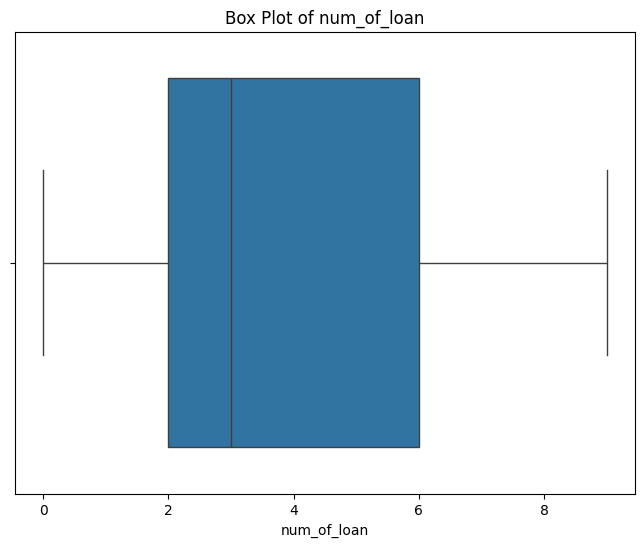

100000


In [127]:
df_converted['num_of_loan'] = df_converted['num_of_loan'].clip(upper=num_of_loan_quantile_value)
df_converted['num_of_loan'] = df_converted['num_of_loan'].clip(lower=0)
df_converted['num_of_loan'] = df_converted['num_of_loan'].fillna(df_converted['num_of_loan'].median())

show_box_plot(df_converted, ['num_of_loan'])

print(len(df_converted))

9. delay_from_due_date

Column: delay_from_due_date
Data Type: int64
Missing Values: 0
Unique Values: 73
Statistical Summary:
count    100000.000000
mean         21.068780
std          14.860104
min          -5.000000
25%          10.000000
50%          18.000000
75%          28.000000
max          67.000000
Name: delay_from_due_date, dtype: float64


delay_from_due_date
 15    3596
 13    3424
 8     3324
 14    3313
 10    3281
       ... 
-4       62
 65      56
-5       33
 66      32
 67      22
Name: count, Length: 73, dtype: int64


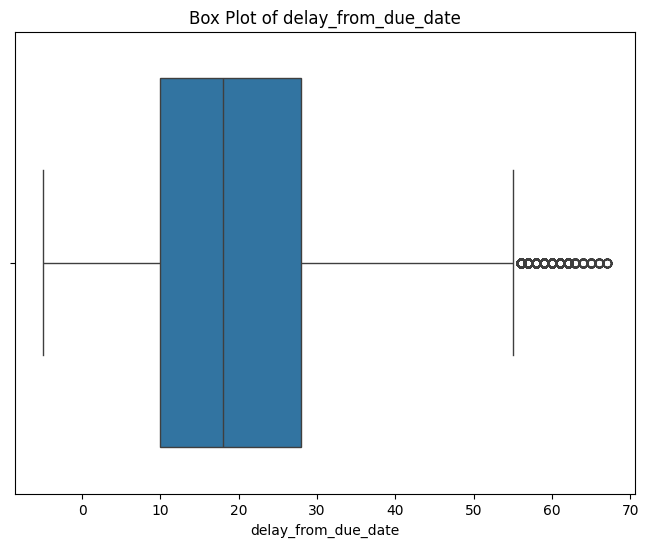

In [128]:
describe_column(df_converted['delay_from_due_date'])

show_box_plot(df_converted, ['delay_from_due_date'])

10. 'num_of_delayed_payment'

Column: num_of_delayed_payment
Data Type: float64
Missing Values: 7002
Unique Values: 708
Statistical Summary:
count    92998.000000
mean        30.946268
std        226.028754
min          0.000000
25%          9.000000
50%         14.000000
75%         18.000000
max       4397.000000
Name: num_of_delayed_payment, dtype: float64


num_of_delayed_payment
19.0      5481
17.0      5412
16.0      5312
10.0      5309
15.0      5237
          ... 
1480.0       1
145.0        1
1820.0       1
4292.0       1
3707.0       1
Name: count, Length: 708, dtype: int64


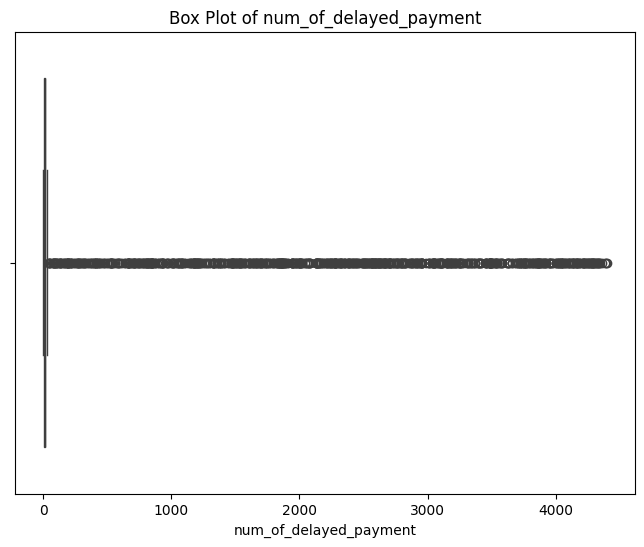

In [129]:
describe_column(df_converted.num_of_delayed_payment)

show_box_plot(df_converted, ['num_of_delayed_payment'])

Quantile value of 0.99: 27.0
31078    27.0
88926    27.0
32257    27.0
75466    27.0
40648    27.0
76074    27.0
95106    27.0
90235    27.0
53829    27.0
94781    27.0
Name: num_of_delayed_payment, dtype: float64


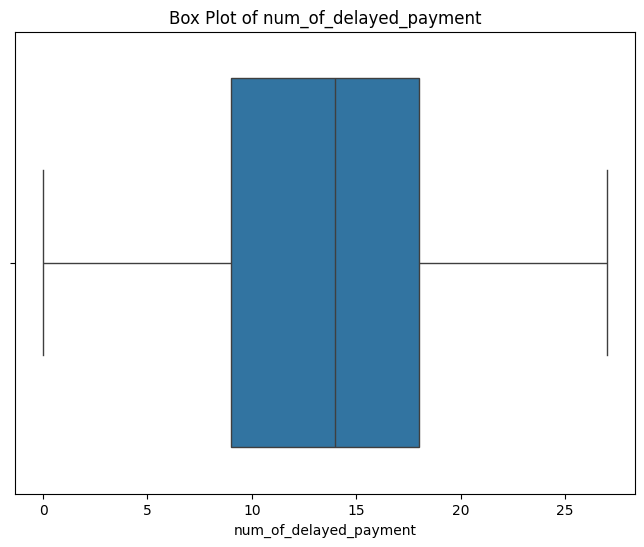

In [130]:
num_of_delayed_payment_quantile = 0.99

num_of_delayed_payment_quantile_value = df_converted.num_of_delayed_payment.quantile(num_of_delayed_payment_quantile)

print(f"Quantile value of {num_of_delayed_payment_quantile}: {num_of_delayed_payment_quantile_value}")

num_of_delayed_payment_quantile_values = df_converted.num_of_delayed_payment[df_converted.num_of_delayed_payment <= num_of_delayed_payment_quantile_value]

print(num_of_delayed_payment_quantile_values.sort_values().tail(10))

show_box_plot(num_of_delayed_payment_quantile_values.to_frame(), ['num_of_delayed_payment'])

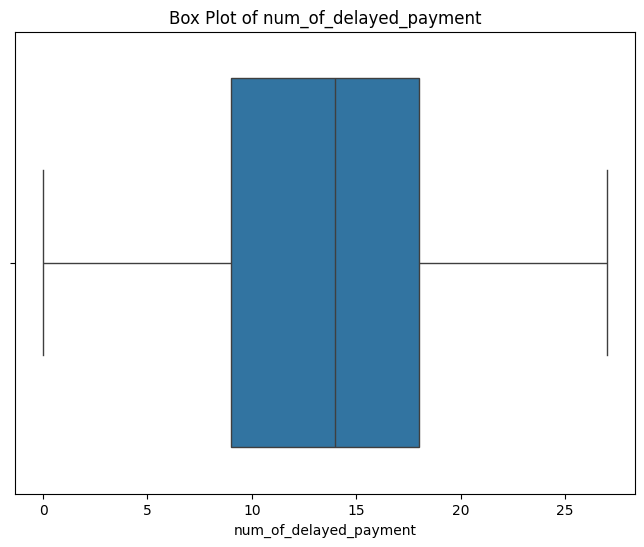

100000


In [131]:
df_converted['num_of_delayed_payment'] = df_converted['num_of_delayed_payment'].clip(upper=num_of_delayed_payment_quantile_value)
df_converted['num_of_delayed_payment'] = df_converted['num_of_delayed_payment'].clip(lower=0)
df_converted['num_of_delayed_payment'] = df_converted['num_of_delayed_payment'].fillna(df_converted['num_of_delayed_payment'].median())

show_box_plot(df_converted, ['num_of_delayed_payment'])

print(len(df_converted))

11. 'cnaged_credit_limit'

Column: cnaged_credit_limit
Data Type: float64
Missing Values: 2091
Unique Values: 3497
Statistical Summary:
count    9.790900e+04
mean     6.304669e+14
std      4.904918e+15
min      0.000000e+00
25%      4.050000e+02
50%      9.010000e+02
75%      1.495000e+03
max      7.970000e+16
Name: cnaged_credit_limit, dtype: float64


cnaged_credit_limit
1.150000e+02    157
9.200000e+01    157
1.160000e+02    149
8.300000e+01    148
1.970000e+02    136
               ... 
3.211000e+03      1
1.663000e+03      1
1.242000e+16      1
3.316000e+03      1
4.710000e+15      1
Name: count, Length: 3497, dtype: int64
0.0


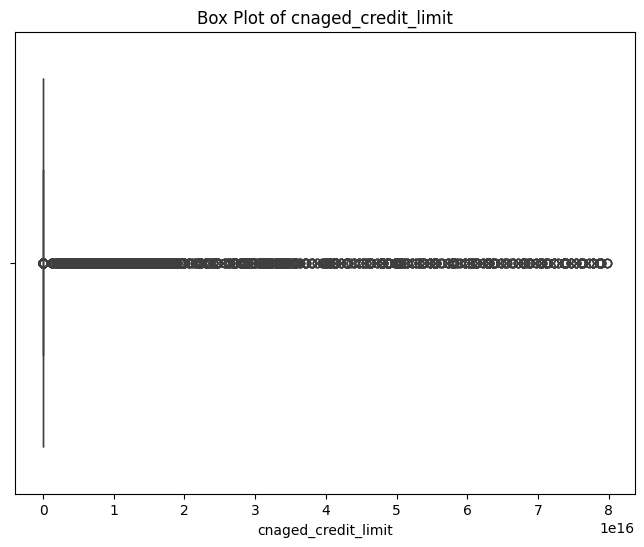

In [132]:
describe_column(df_converted['cnaged_credit_limit'])
print(df_converted['cnaged_credit_limit'].min())

show_box_plot(df_converted, ['cnaged_credit_limit'])

Quantile value of 0.96: 2863.0
89284    2863.0
89285    2863.0
89286    2863.0
8559     2863.0
82069    2863.0
82068    2863.0
82067    2863.0
82070    2863.0
82071    2863.0
82064    2863.0
Name: cnaged_credit_limit, dtype: float64


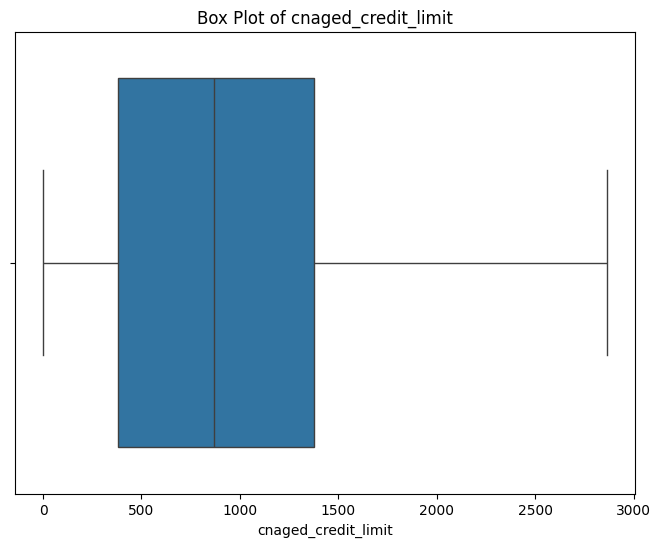

In [133]:
cnaged_credit_limit_quantile = 0.96

cnaged_credit_limit_quantile_value = df_converted.cnaged_credit_limit.quantile(cnaged_credit_limit_quantile)

print(f"Quantile value of {cnaged_credit_limit_quantile}: {cnaged_credit_limit_quantile_value}")

cnaged_credit_limit_quantile_values = df_converted.cnaged_credit_limit[df_converted.cnaged_credit_limit <= cnaged_credit_limit_quantile_value]

print(cnaged_credit_limit_quantile_values.sort_values().tail(10))

show_box_plot(cnaged_credit_limit_quantile_values.to_frame(), ['cnaged_credit_limit'])

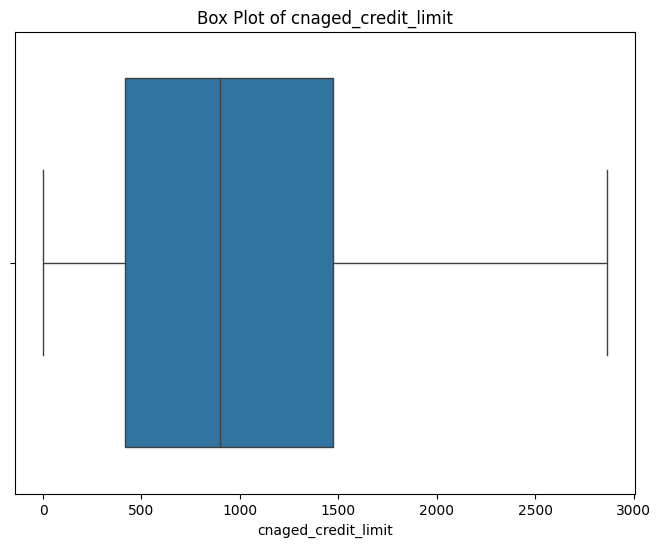

100000


In [134]:
df_converted['cnaged_credit_limit'] = df_converted['cnaged_credit_limit'].clip(upper=cnaged_credit_limit_quantile_value)
df_converted['cnaged_credit_limit'] = df_converted['cnaged_credit_limit'].clip(lower=0)
df_converted['cnaged_credit_limit'] = df_converted['cnaged_credit_limit'].fillna(df_converted['cnaged_credit_limit'].median())

show_box_plot(df_converted, ['cnaged_credit_limit'])

print(len(df_converted))

12. 'num_credit_inquiries'

Column: num_credit_inquiries
Data Type: float64
Missing Values: 1965
Unique Values: 1223
Statistical Summary:
count    98035.000000
mean        27.754251
std        193.177339
min          0.000000
25%          3.000000
50%          6.000000
75%          9.000000
max       2597.000000
Name: num_credit_inquiries, dtype: float64


num_credit_inquiries
4.0       11271
3.0        8890
6.0        8111
7.0        8058
2.0        8028
          ...  
1618.0        1
758.0         1
735.0         1
2483.0        1
1960.0        1
Name: count, Length: 1223, dtype: int64
0.0


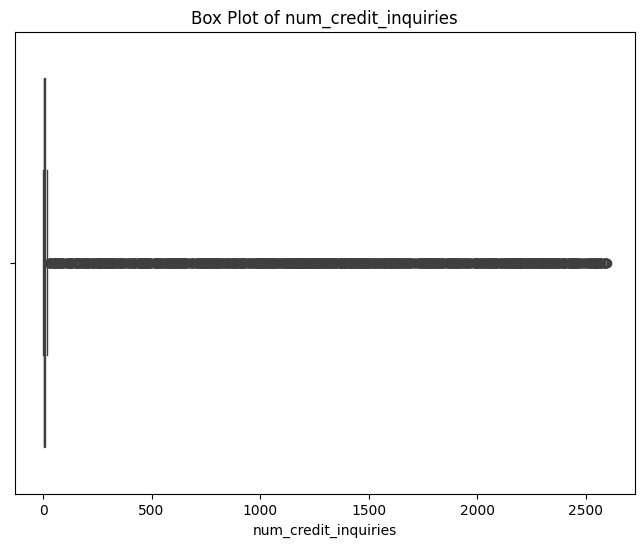

In [135]:
describe_column(df_converted.num_credit_inquiries)
print(df_converted.num_credit_inquiries.min())

show_box_plot(df_converted, ['num_credit_inquiries'])

Quantile of 0.98: 16.0


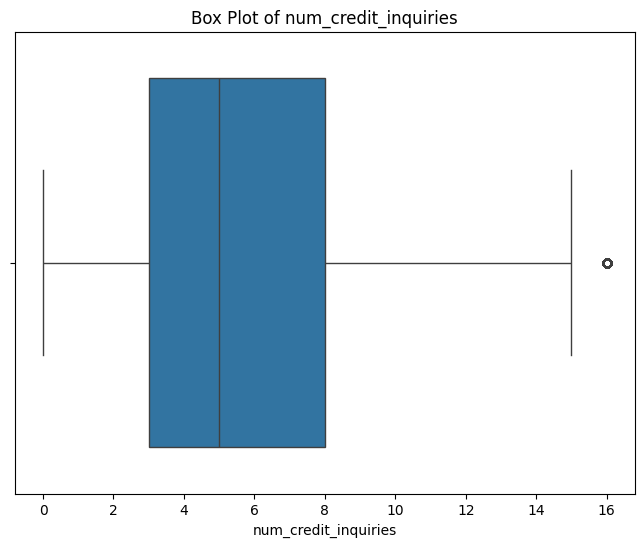

In [136]:
num_credit_inquiries_quantile = 0.98

num_credit_inquiries_value = df_converted.num_credit_inquiries.quantile(num_credit_inquiries_quantile)

print(f"Quantile of {num_credit_inquiries_quantile}: {num_credit_inquiries_value}")

num_credit_inquiries_values = df_converted.num_credit_inquiries[df_converted.num_credit_inquiries <= num_credit_inquiries_value]

show_box_plot(num_credit_inquiries_values.to_frame(), ['num_credit_inquiries'])

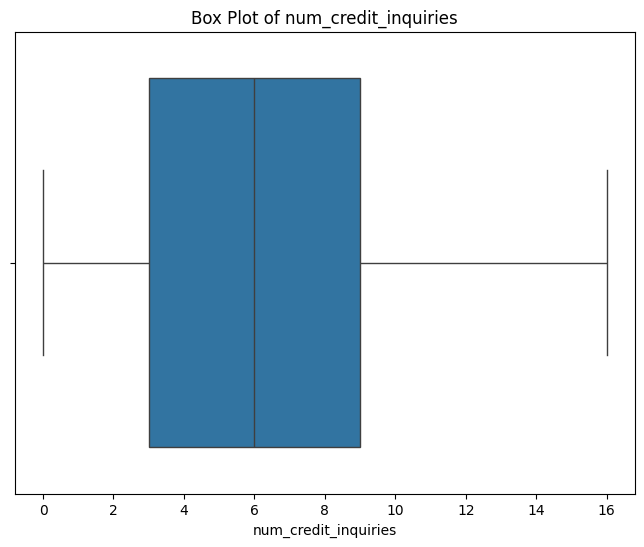

100000
Column: num_credit_inquiries
Data Type: float64
Missing Values: 0
Unique Values: 17
Statistical Summary:
count    100000.000000
mean          5.951190
std           4.000056
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          16.000000
Name: num_credit_inquiries, dtype: float64


num_credit_inquiries
4.0     11271
6.0     10076
3.0      8890
7.0      8058
2.0      8028
8.0      7866
1.0      7588
0.0      6972
5.0      5693
9.0      5283
11.0     5051
10.0     4936
12.0     4571
16.0     2390
13.0     1480
14.0     1039
15.0      808
Name: count, dtype: int64


In [137]:
df_converted['num_credit_inquiries'] = df_converted['num_credit_inquiries'].clip(upper=num_credit_inquiries_value)
df_converted['num_credit_inquiries'] = df_converted['num_credit_inquiries'].clip(lower=0)
df_converted['num_credit_inquiries'] = df_converted['num_credit_inquiries'].fillna(df_converted['num_credit_inquiries'].median())

show_box_plot(df_converted, ['num_credit_inquiries'])

print(len(df_converted))

describe_column(df_converted.num_credit_inquiries)

13. 'outstanding_debt' - Represents the remaining debt to be paid (in USD) (Представляет собой оставшуюся сумму задолженности к выплате (в долларах США))

Column: outstanding_debt
Data Type: float64
Missing Values: 0
Unique Values: 12203
Statistical Summary:
count    100000.000000
mean       1426.220376
std        1155.129026
min           0.230000
25%         566.072500
50%        1166.155000
75%        1945.962500
max        4998.070000
Name: outstanding_debt, dtype: float64


outstanding_debt
1151.70    24
460.46     24
1109.03    24
1360.45    24
1457.54    16
           ..
177.90      8
2542.42     8
1095.90     8
4523.30     8
1704.18     8
Name: count, Length: 12203, dtype: int64
0.23


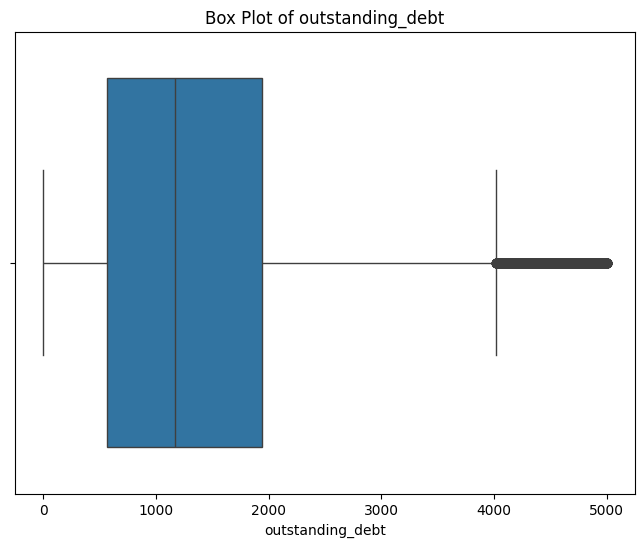

In [138]:
describe_column(df_converted['outstanding_debt'])
print(df_converted.outstanding_debt.min())

show_box_plot(df_converted, ['outstanding_debt'])

14. credit_history_age

Column: credit_history_age
Data Type: float64
Missing Values: 9030
Unique Values: 404
Statistical Summary:
count    90970.000000
mean       221.195405
std         99.741364
min          1.000000
25%        144.000000
50%        219.000000
75%        302.000000
max        404.000000
Name: credit_history_age, dtype: float64


credit_history_age
191.0    446
232.0    445
233.0    444
215.0    443
231.0    441
        ... 
3.0       20
2.0       15
403.0     14
404.0     12
1.0        2
Name: count, Length: 404, dtype: int64


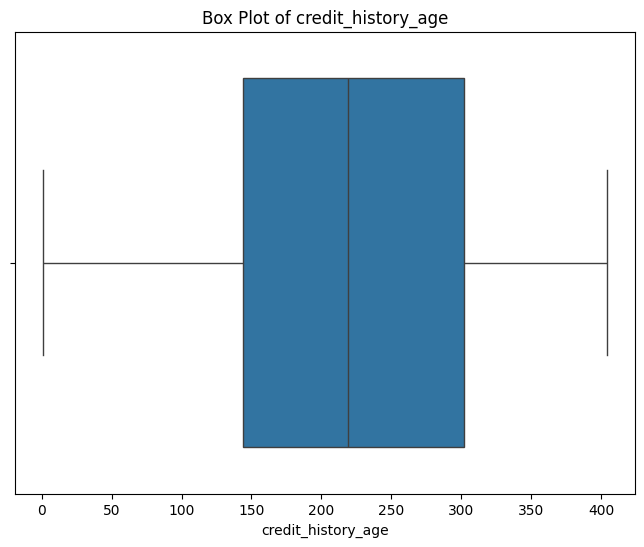

In [139]:
describe_column(df_converted.credit_history_age)

show_box_plot(df_converted, ['credit_history_age'])

Column: credit_history_age
Data Type: float64
Missing Values: 0
Unique Values: 404
Statistical Summary:
count    100000.000000
mean        220.997160
std          95.133546
min           1.000000
25%         154.000000
50%         219.000000
75%         292.000000
max         404.000000
Name: credit_history_age, dtype: float64


credit_history_age
219.0    9458
191.0     446
232.0     445
233.0     444
215.0     443
         ... 
3.0        20
2.0        15
403.0      14
404.0      12
1.0         2
Name: count, Length: 404, dtype: int64


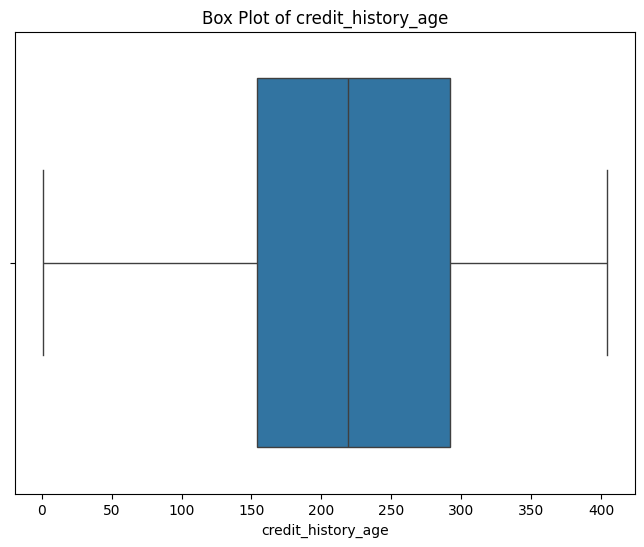

In [140]:
df_converted.credit_history_age = df_converted.credit_history_age.fillna(df_converted.credit_history_age.median())

describe_column(df_converted.credit_history_age)

show_box_plot(df_converted, ['credit_history_age'])

15. 'payment_of_min_amount'

Column: payment_of_min_amount
Data Type: float64
Missing Values: 12007
Unique Values: 2
Statistical Summary:
count    87993.000000
mean         0.594661
std          0.490960
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: payment_of_min_amount, dtype: float64


payment_of_min_amount
1.0    52326
0.0    35667
Name: count, dtype: int64


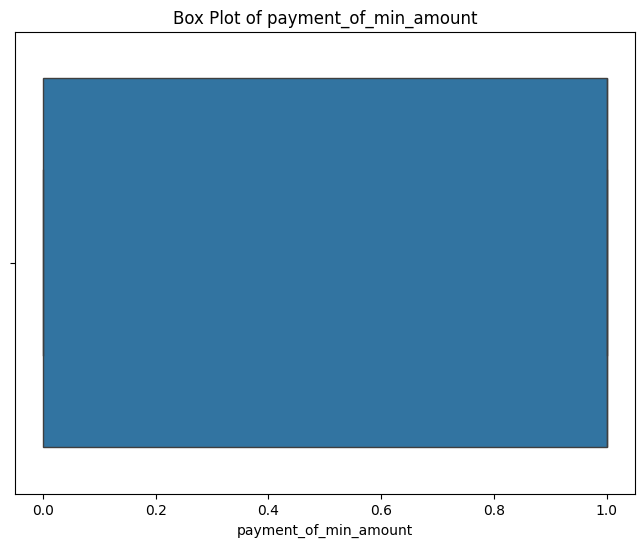

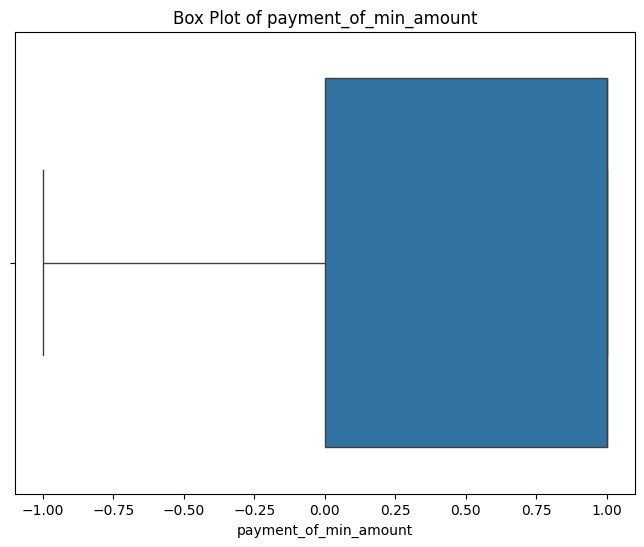

In [141]:
describe_column(df_converted.payment_of_min_amount)

show_box_plot(df_converted, ['payment_of_min_amount'])

df_converted.payment_of_min_amount = df_converted.payment_of_min_amount.fillna(-1)

show_box_plot(df_converted, ['payment_of_min_amount'])

17. 'total_emi_per_month' - Represents the monthly EMI payments (in USD) (Отображает ежемесячные платежи по кредиту (в долларах США))

Column: total_emi_per_month
Data Type: float64
Missing Values: 0
Unique Values: 14950
Statistical Summary:
count    100000.000000
mean       1403.118217
std        8306.041270
min           0.000000
25%          30.306660
50%          69.249473
75%         161.224249
max       82331.000000
Name: total_emi_per_month, dtype: float64


total_emi_per_month
0.000000        10613
31.086195           8
149.897199          8
62.222285           8
171.430198          8
                ...  
33746.000000        1
39347.000000        1
27292.000000        1
16627.000000        1
49430.000000        1
Name: count, Length: 14950, dtype: int64
0.0


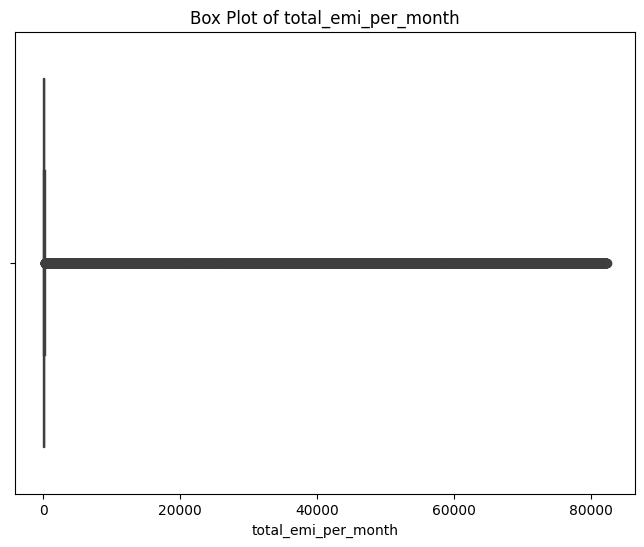

In [142]:
describe_column(df_converted.total_emi_per_month)
print(df_converted.total_emi_per_month.min())

show_box_plot(df_converted, ['total_emi_per_month'])

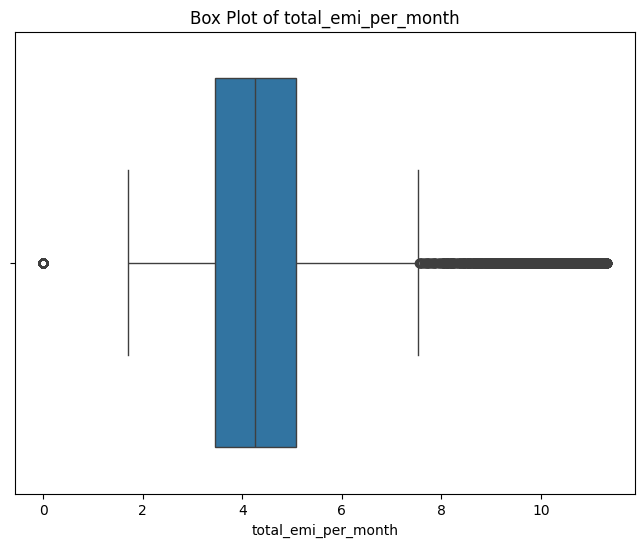

In [143]:
total_emi_log_converted = np.log1p(df_converted['total_emi_per_month'])

show_box_plot(total_emi_log_converted.to_frame(), ['total_emi_per_month'])

df_converted['total_emi_per_month'] = total_emi_log_converted

18. amount_invested_monthly

Column: amount_invested_monthly
Data Type: float64
Missing Values: 8784
Unique Values: 91048
Statistical Summary:
count    91216.000000
mean       195.539456
std        199.564527
min          0.000000
25%         72.236692
50%        128.954538
75%        236.815814
max       1977.326102
Name: amount_invested_monthly, dtype: float64


amount_invested_monthly
0.000000      169
43.370670       1
42.935566       1
104.291825      1
167.163865      1
             ... 
215.486386      1
78.497727       1
147.339908      1
82.825572       1
124.881820      1
Name: count, Length: 91048, dtype: int64
0.0


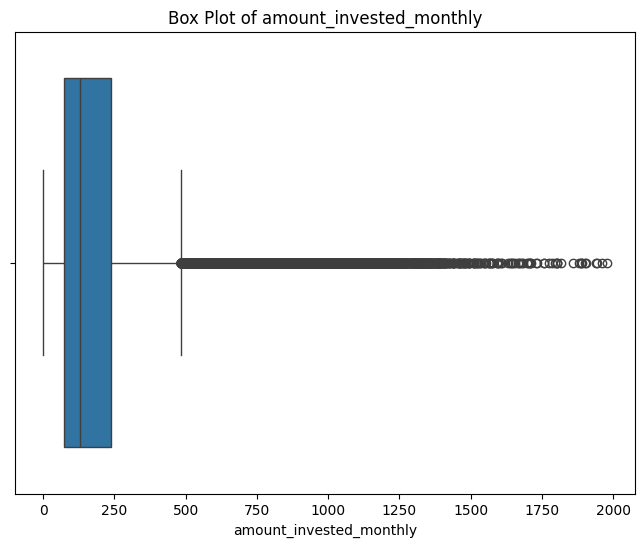

In [144]:
describe_column(df_converted.amount_invested_monthly)
print(df_converted.amount_invested_monthly.min())

show_box_plot(df_converted, ['amount_invested_monthly'])

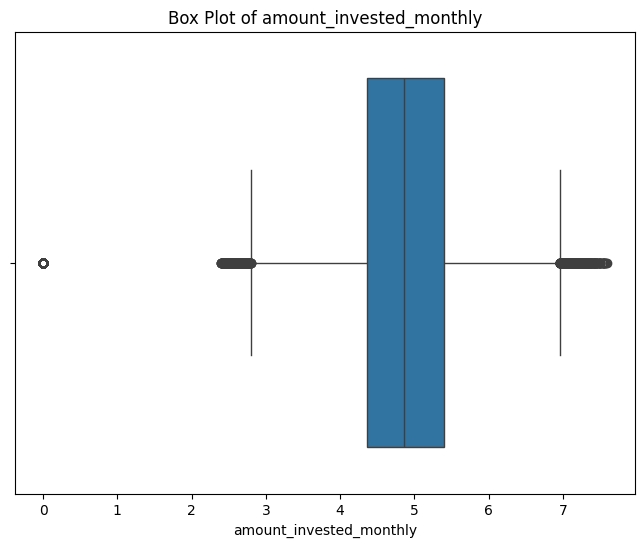

In [145]:
df_converted.amount_invested_monthly = df_converted.amount_invested_monthly.fillna(df_converted.amount_invested_monthly.median())

amount_invested_monthly_log = np.log1p(df_converted.amount_invested_monthly)

show_box_plot(amount_invested_monthly_log.to_frame(), ['amount_invested_monthly'])

df_converted.amount_invested_monthly = amount_invested_monthly_log

19. 'monthly_balance'

Column: monthly_balance
Data Type: float64
Missing Values: 2877
Unique Values: 97123
Statistical Summary:
count    97123.000000
mean       402.164483
std        213.644217
min          0.007760
25%        269.998334
50%        336.472111
75%        469.652004
max       1602.040519
Name: monthly_balance, dtype: float64


monthly_balance
214.614934    1
312.494089    1
284.629162    1
375.208127    1
325.893766    1
             ..
358.124168    1
244.565317    1
340.479212    1
341.489231    1
223.451310    1
Name: count, Length: 97123, dtype: int64


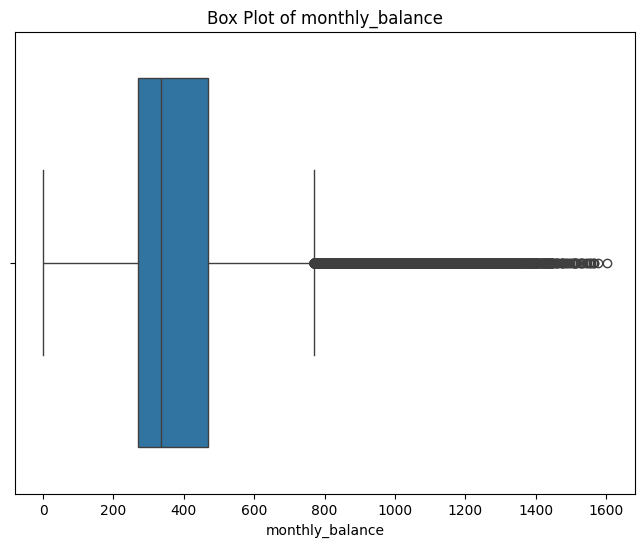

In [146]:
describe_column(df_converted.monthly_balance)

show_box_plot(df_converted, ['monthly_balance'])

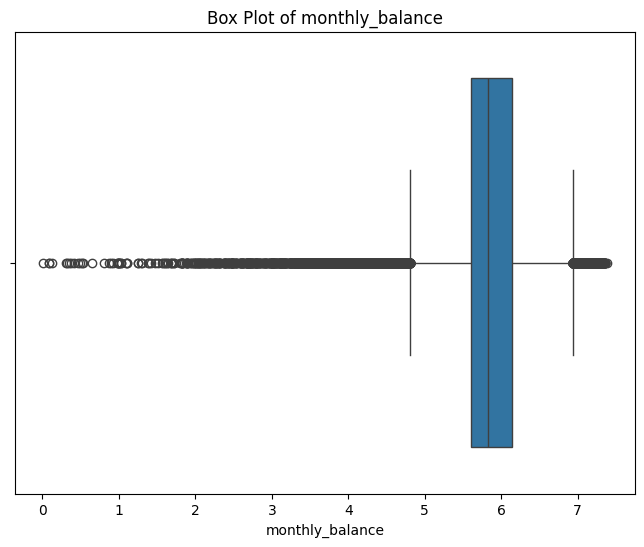

In [147]:
df_converted.monthly_balance = df_converted.monthly_balance.fillna(df_converted.monthly_balance.median())

monthly_balance_log = np.log1p(df_converted.monthly_balance)

show_box_plot(monthly_balance_log.to_frame(), ['monthly_balance'])

In [148]:
df_converted.monthly_balance = monthly_balance_log

20. credit_utilization_ratio - Represents the utilization ratio of credit card (Отражает коэффициент использования кредитной карты)

Column: credit_utilization_ratio
Data Type: float64
Missing Values: 0
Unique Values: 100000
Statistical Summary:
count    100000.000000
mean         32.285173
std           5.116875
min          20.000000
25%          28.052567
50%          32.305784
75%          36.496663
max          50.000000
Name: credit_utilization_ratio, dtype: float64


credit_utilization_ratio
39.300980    1
38.850680    1
37.753013    1
27.495263    1
36.979007    1
            ..
24.797347    1
31.377862    1
28.609352    1
31.944960    1
26.822620    1
Name: count, Length: 100000, dtype: int64


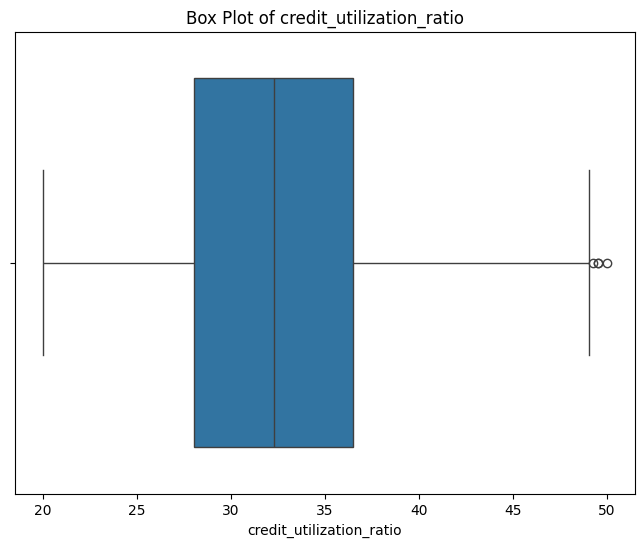

In [149]:
describe_column(df_converted.credit_utilization_ratio)

show_box_plot(df_converted, ['credit_utilization_ratio'])

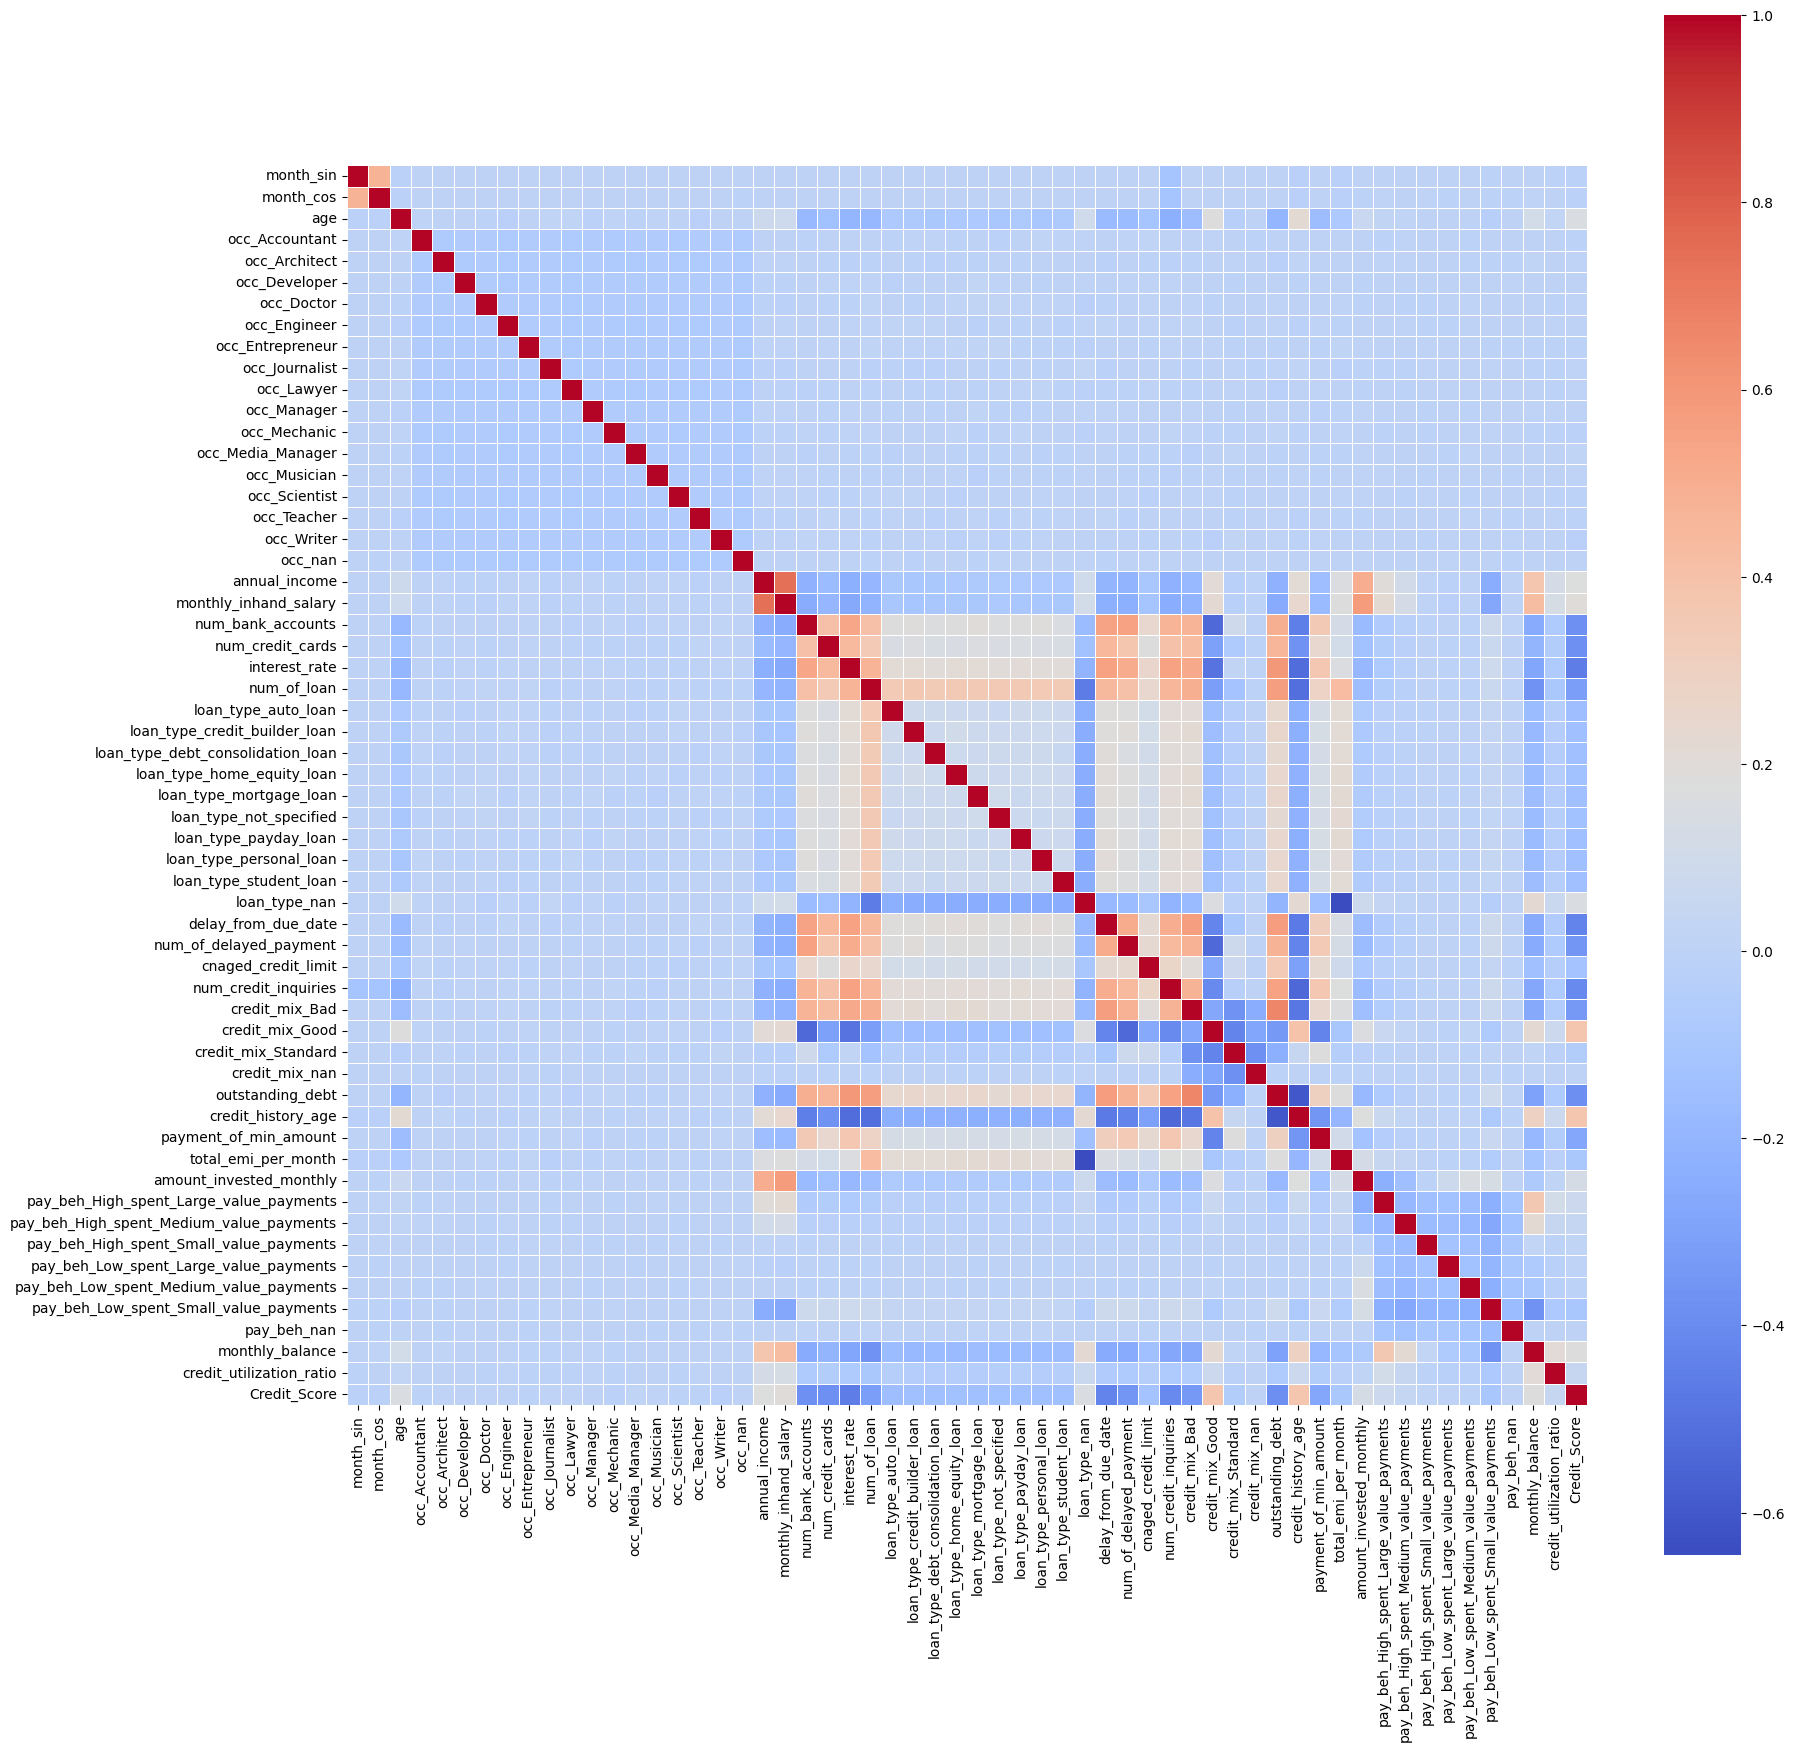

In [150]:
show_corr_matrix(df_converted)

In [151]:
print(df_converted.columns)

Index(['month_sin', 'month_cos', 'age', 'occ_Accountant', 'occ_Architect',
       'occ_Developer', 'occ_Doctor', 'occ_Engineer', 'occ_Entrepreneur',
       'occ_Journalist', 'occ_Lawyer', 'occ_Manager', 'occ_Mechanic',
       'occ_Media_Manager', 'occ_Musician', 'occ_Scientist', 'occ_Teacher',
       'occ_Writer', 'occ_nan', 'annual_income', 'monthly_inhand_salary',
       'num_bank_accounts', 'num_credit_cards', 'interest_rate', 'num_of_loan',
       'loan_type_auto_loan', 'loan_type_credit_builder_loan',
       'loan_type_debt_consolidation_loan', 'loan_type_home_equity_loan',
       'loan_type_mortgage_loan', 'loan_type_not_specified',
       'loan_type_payday_loan', 'loan_type_personal_loan',
       'loan_type_student_loan', 'loan_type_nan', 'delay_from_due_date',
       'num_of_delayed_payment', 'cnaged_credit_limit', 'num_credit_inquiries',
       'credit_mix_Bad', 'credit_mix_Good', 'credit_mix_Standard',
       'credit_mix_nan', 'outstanding_debt', 'credit_history_age',
       

In [210]:
X = df_converted.drop(columns=['Credit_Score'])

y = df_converted.Credit_Score

In [211]:
num_cols = [
    'month_sin', 'month_cos',
    'age',
    'annual_income',
    'monthly_inhand_salary',
    'num_bank_accounts',
    'num_credit_cards',
    'interest_rate',
    'num_of_loan',
    'delay_from_due_date',
    'num_of_delayed_payment',
    'cnaged_credit_limit',
    'num_credit_inquiries',
    'outstanding_debt',
    'credit_history_age',
    'total_emi_per_month',
    'amount_invested_monthly',
    'monthly_balance',
    'credit_utilization_ratio'
]


In [218]:
cat_cols = [c for c in X.columns if c not in num_cols]

print(cat_cols)

[]


In [221]:
from sklearn.metrics import silhouette_score

In [219]:
scaler = StandardScaler()

X = X.drop(columns=cat_cols)

print(X.columns)

X_prepared = scaler.fit_transform(X)

Index(['month_sin', 'month_cos', 'age', 'annual_income',
       'monthly_inhand_salary', 'num_bank_accounts', 'num_credit_cards',
       'interest_rate', 'num_of_loan', 'delay_from_due_date',
       'num_of_delayed_payment', 'cnaged_credit_limit', 'num_credit_inquiries',
       'outstanding_debt', 'credit_history_age', 'total_emi_per_month',
       'amount_invested_monthly', 'monthly_balance',
       'credit_utilization_ratio'],
      dtype='object')


In [225]:
def plot_clusters(X_2d, labels, title):
    plt.figure(figsize=(6, 5))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=15)
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

In [224]:
pca = PCA(n_components=3, random_state=52)

X_pca = pca.fit_transform(X_prepared)

1. Рассмотрим DBSCAN

In [222]:
def get_hyper_parameters(eps_arr, min_samples_arr, X):
    best_score = -1
    best_params = None

    for eps in eps_arr:
        for min_samples in min_samples_arr:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)

            unique_labels = set(labels)
            if len(unique_labels) <= 1 or (unique_labels == {-1}):
                continue

            mask = labels != -1
            if len(set(labels[mask])) < 2:
                continue

            score = silhouette_score(X[mask], labels[mask])

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

    return best_params, best_score


eps_arr = np.arange(0.1, 1.1, 0.2)
min_samples_arr = np.arange(2, 21, 1)

(best_eps, best_min_samples), best_score = get_hyper_parameters(
    eps_arr,
    min_samples_arr,
    X_prepared
)

print(f'Best eps: {best_eps}')
print(f'Best min_samples: {best_min_samples}')
print(f'Best silhouette: {best_score:.3f}')

Best eps: 0.9000000000000001
Best min_samples: 3
Best silhouette: 0.736


In [223]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)

y_dbscan = dbscan.fit_predict(X_prepared)

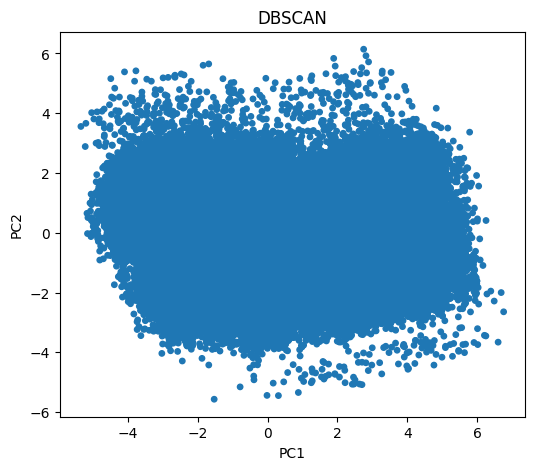

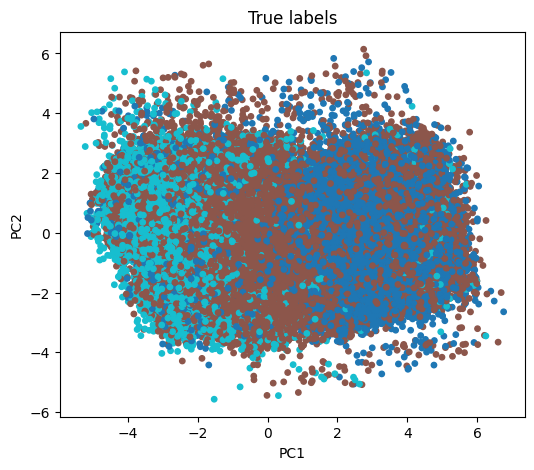

In [226]:
plot_clusters(X_pca, y_dbscan, 'DBSCAN')
plot_clusters(X_pca, y, 'True labels')

In [229]:
from sklearn.metrics import adjusted_rand_score

mask = y_dbscan != -1

ari = adjusted_rand_score(y[mask], y_dbscan[mask])

unique_labels = set(y_dbscan)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
noise_ratio = np.mean(y_dbscan == -1)

print(f"Количество кластеров: {n_clusters}")
print(f"Метки кластеров: {unique_labels}")
print(f"Доля шума: {noise_ratio:.2%}")
print(f"ARI (без шума): {ari:.3f}")

Количество кластеров: 5
Метки кластеров: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(-1)}
Доля шума: 99.98%
ARI (без шума): 0.415


2. Рассмотрим KMeans

In [234]:
def get_best_kmeans_k(k_range, X):
    best_score = -1
    best_k = None
    best_labels = None

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=52)
        labels = kmeans.fit_predict(X)

        if len(set(labels)) < 2:
            continue
        
        score = silhouette_score(X, labels)
        
        if score > best_score:
            best_score = score
            best_k = k
            best_labels = labels

    return best_k, best_labels, best_score


In [240]:
k_range = range(3, 21)

best_k, y_kmeans, best_score = get_best_kmeans_k(k_range, X_prepared)

print(f"Лучшее количество кластеров: {best_k}")
print(f"Лучший Silhouette Score: {best_score:.3f}")


Лучшее количество кластеров: 3
Лучший Silhouette Score: 0.132


In [241]:
kmeans = KMeans(n_clusters=best_k, random_state=52, n_init=20)

y_kmeans = kmeans.fit_predict(X_prepared)

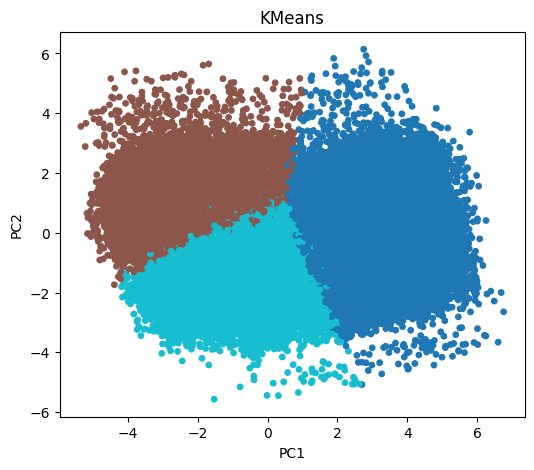

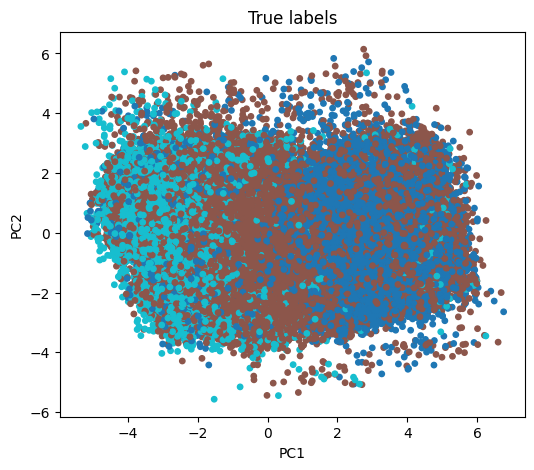

In [242]:
plot_clusters(X_pca, y_kmeans, 'KMeans')
plot_clusters(X_pca, y, 'True labels')


In [243]:
from sklearn.metrics import adjusted_rand_score

mask = y_kmeans != -1

ari = adjusted_rand_score(y[mask], y_kmeans[mask])

unique_labels = set(y_kmeans)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
noise_ratio = np.mean(y_kmeans == -1)

print(f"Количество кластеров: {n_clusters}")
print(f"Метки кластеров: {unique_labels}")
print(f"Доля шума: {noise_ratio:.2%}")
print(f"ARI (без шума): {ari:.3f}")

Количество кластеров: 3
Метки кластеров: {np.int32(0), np.int32(1), np.int32(2)}
Доля шума: 0.00%
ARI (без шума): 0.116


In [254]:
from sklearn.cluster import OPTICS

def get_best_optics_params(X, min_samples_arr, xi_arr, min_cluster_size_arr):
    best_score = -1
    best_params = None
    best_labels = None

    for min_samples in min_samples_arr:
        for xi in xi_arr:
            for min_cluster_size in min_cluster_size_arr:
                optics = OPTICS(
                    min_samples=min_samples,
                    xi=xi,
                    min_cluster_size=min_cluster_size
                )

                labels = optics.fit_predict(X)

                mask = labels != -1
                unique_clusters = set(labels[mask])

                if len(unique_clusters) < 2:
                    continue

                try:
                    score = silhouette_score(X[mask], labels[mask])
                except ValueError:
                    continue

                if score > best_score:
                    best_score = score
                    best_params = {
                        'min_samples': min_samples,
                        'xi': xi,
                        'min_cluster_size': min_cluster_size
                    }
                    best_labels = labels

    return best_params, best_labels, best_score

In [255]:
min_samples_arr = [5, 10, 15, 20]
xi_arr = [0.03, 0.05, 0.1]
min_cluster_size_arr = [0.03, 0.05, 0.1]

best_params, y_optics, best_score = get_best_optics_params(
    X_prepared,
    min_samples_arr,
    xi_arr,
    min_cluster_size_arr
)

print("Лучшие параметры OPTICS:")
print(best_params)
print(f"Лучший Silhouette Score: {best_score:.3f}")

Лучшие параметры OPTICS:
None
Лучший Silhouette Score: -1.000


C:\Users\MypkaXD\AppData\Local\Temp\ipykernel_956\2268321926.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=15)


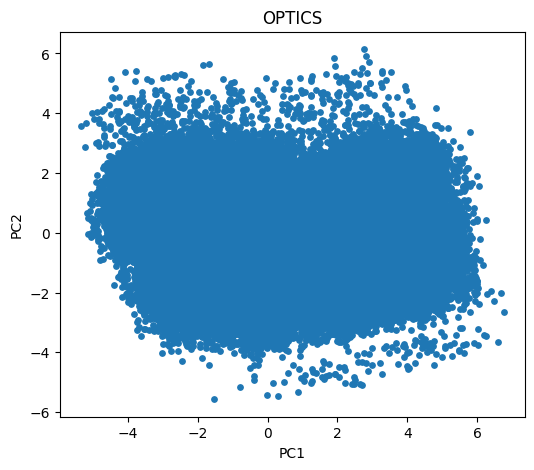

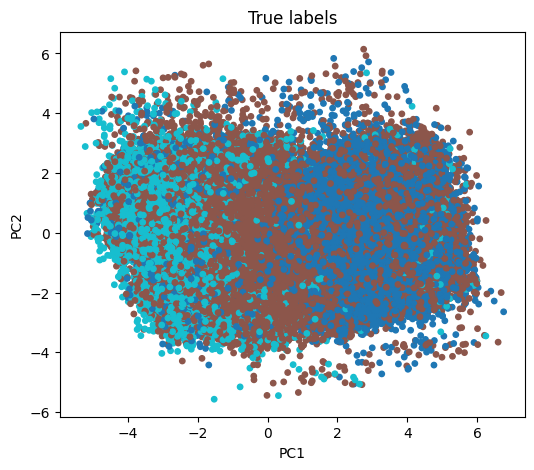

In [256]:
plot_clusters(X_pca, y_optics, 'OPTICS')
plot_clusters(X_pca, y, 'True labels')

In [257]:
from sklearn.metrics import adjusted_rand_score

mask = y_optics != -1

ari = adjusted_rand_score(y[mask], y_optics[mask])

unique_labels = set(y_optics)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
noise_ratio = np.mean(y_optics == -1)

print(f"Количество кластеров: {n_clusters}")
print(f"Метки кластеров: {unique_labels}")
print(f"Доля шума: {noise_ratio:.2%}")
print(f"ARI (без шума): {ari:.3f}")

KeyError: True

Результаты вышли так себе, одной из причин, как я считаю, может быть большое кол-во признаков и сильный дисбаланс классов.

In [264]:
ARIs = {
    "OPTICS" : 0.0,
    "KMeans" : 0.116,
    "DBSCAN" : 0.415
    }

Silhouette_Scores = {
    "OPTICS" : -1.000,
    "KMeans": 0.132,
    "DBSCAN": 0.736
}

models = ["OPTICS", "KMeans", "DBSCAN"]

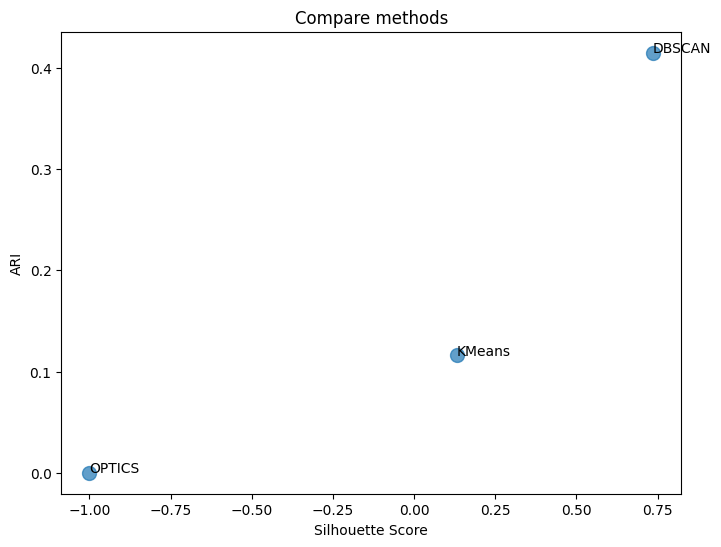

In [267]:
plt.figure(figsize=(8, 6))
plt.scatter(Silhouette_Scores.values(), ARIs.values(), s=100, alpha=0.7)

for model in (models):
    plt.text(Silhouette_Scores[model], ARIs[model], model, fontsize=10)

plt.ylabel('ARI')
plt.xlabel('Silhouette Score')
plt.title('Compare methods')
plt.show()